# Lending Club Case Study
The company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default. 
The company can utilise this knowledge for its portfolio and risk assessment.

For this analysis, let's first import the Python libraries that will be used and define useful functions.

In [1]:
import pandas as pd              # Data manipulation tool
print('Pandas version: ',pd.__version__)
import seaborn as sns            # Data visualisation library
print('Seaborn version: ',sns.__version__)
import matplotlib
import matplotlib.pyplot as plt  # Data visualisation libray
print('Matplotlib version: ',matplotlib.__version__)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') # Ignore warning messages

Pandas version:  1.3.4
Seaborn version:  0.11.2
Matplotlib version:  3.4.3


Following function definition is to get the correct year for a date, as the pandas method to_datetime maps incorrectly to future dates (i.e. Jan-68 to 1/1/2068).

In [2]:
# Function to get the correct year as datetime functions map to future dates (i.e. Jan-68 to 1/1/2068)
def get_year(two_digits):
    if two_digits[0] == '0':
        return '20' + two_digits
    else:
        return '19' + two_digits

## Data cleaning and manipulation

Let's read the file "loan.csv" which contains the data we need, and store it in a variable called "df" (for dataframe):

In [3]:
df = pd.read_csv('loan.csv')

The function info() will let us see at first glance the composition of the data:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


We have <b>111 columns</b> and <b>39,717 records</b>.

Do we really need 111 columns for the analysis? Let's <b>review</b> what kind of data they hold and check <b>whether we can narrow down</b> the amount of columns we'll work with by:

1. Filtering columns by missing values
2. Filtering single-value columns
3. Understanding each column (variable) description to check if it fits in analisys

### Missing values by column
For each column, let's review the count of missing values it holds.

In [5]:
# Get count of missing values, convert result to dataframe for aesthetic reasons
df_null = df.isna().sum().to_frame() 

# Rename aggregated column to "null_count"
df_null.columns = ['null_count']

# Add a column to show the percentage of null values for each column (data-driven metric)
df_null['null_perc'] = df_null['null_count'].apply(lambda x: round(x/len(df) * 100,2))

# Show for each column the count of null values and the percentage of them from "df" total rows
print('Total null values for each column and the percentage from total rows')
df_null.sort_values(by='null_perc', ascending=False)

Total null values for each column and the percentage from total rows


null_count  null_perc
verification_status_joint       39717      100.0
annual_inc_joint                39717      100.0
mo_sin_old_rev_tl_op            39717      100.0
mo_sin_old_il_acct              39717      100.0
bc_util                         39717      100.0
...                               ...        ...
delinq_amnt                         0        0.0
policy_code                         0        0.0
earliest_cr_line                    0        0.0
delinq_2yrs                         0        0.0
id                                  0        0.0

[111 rows x 2 columns]

We can see some columns have null/empty values only...

- How many of them? 
- Are there columns with a high percentage of null values?

In [6]:
# Group columns by percentage of null values to understand the null values distribution
df_null_groupby = pd.pivot_table(df_null, index='null_perc', values='null_count', aggfunc='count')
df_null_groupby.columns = ['columns_count']

# Show results sorted by percentage of null values
df_null_groupby.sort_values(by='null_perc', ascending=False)

columns_count
null_perc               
100.00                54
97.13                  1
92.99                  1
64.66                  1
32.58                  1
6.19                   1
2.71                   1
1.75                   1
0.18                   1
0.14                   2
0.13                   1
0.10                   1
0.03                   1
0.01                   1
0.00                  43

We can see that <b>54 columns contain null values only</b>. As this columns do not add information to the analysis we can get rid of them.

2 columns have more than 90% null values, 1 more than 60% null values, 1 more than 30% of null values, and the rest of them less than 30% of null values. **We'll remove variables with more than 60% null values**.

Let's take a <b>closer look</b> to the <b>column with more than 30% null values</b>.


In [7]:
# Filter the dataframe with null values by null_perc
df_null_names = df_null[df_null.null_perc==32.58]

# Get column names of those who have more than 30% null values
list(df_null_names.index)

['desc']

<b>"desc" column review</b>

This column contains the loan description provided by the borrower.

The description of the loan could be useful if the column is categorical as we can find a "trend" for certain categories. Let's take a look at its unique values.

In [8]:
# 39717 total values
print('Unique values of \'desc\' column: ', len(df.desc.unique()))

Unique values of 'desc' column:  26528


From the values that contain a description (non-null values), almost all of them are unique: 26,528 out of 26,777.

For an analytical view, a column with different values in each record does not point to an specific trend (borrowers can give multiple descriptions for the same type of loan), and does not add value to the final analysis. **We can get rid of this column**.

<b>First decision for columns with missing values</b>

We will get rid of columns with more than 30% of missing values, that leaves 53 columns.

From those 53 columns we have 1 column has 6.19% of missing values, 1 column has 2.71% missing values, 1 column has 1.75% missing values, and the rest (50 columns) have less than 0.2% missing values.

To keep all columns in a similar range of percentage of missing values,<b>we'll keep columns with less than 5% of missing values</b> (later on we'll also clean columns accordingly to their definition or unique values). <b>We will have 52 columns.</b> 

Will removing 'emp_title' column significantly affect the results?
'emp_title' column contains the job title supplied by the Borrower when applying for the loan. Similar to "desc" column that was removed, borrowers can give multiple titles for the same type of employment and no specific trend can be followed.

In [9]:
# Filter the values on df_null data
df_null = df_null[df_null.null_perc < 5.0]

# Get columns names to keep in a list
keep_columns = list(df_null.index)

# Filter main dataset "df" to keep those columns only
df = df[keep_columns]

### Columns with a single value
We have removed some columns with all values being different (unique), but what about columns with a single value (same value for all rows)?

These kind of columns do not add information for the results as the variance is zero, situation that can cause errors or unexpected results. We'll remove this columns.

In [10]:
# Use the nunique pandas function to count number of distinct elements in specified axis
# Filter "df" dataset to keep columns with result different of one (not single values)
df = df.loc[:,df.apply(pd.Series.nunique) != 1]
print('Total columns: ', len(df.columns))

Total columns:  43


After removing columns with a single value, <b>we have 43 columns</b>.

### Column description
For the remaining columns we'll review their description to decide if data it's meaningful for our objective, and check if it correctly represents a loan application.

We want to obtain the variables which are strong indicators of default BEFORE the loan has been approved. So <b>we want to get rid of the variables that were updated after loan approval</b>.

According to data dictionary, following variables represent updates after the loan approval, we will get rid of them:

- collection_recovery_fee: post charge off collection fee.
- funded_amnt: the total amount committed to that loan at that point in time.
- funded_amnt_inv: the total amount committed by investors for that loan at that point in time.
- issue_d: the month which the loan was funded.
- last_credit_pull_d: the most recent month LC pulled credit for this loan.
- last_pymnt_amnt: last total payment amount received.
- last_pymnt_d: last month payment was received.
- out_prncp: remaining outstanding principal for total amount funded.
- out_prncp_inv: remaining outstanding principal for portion of total amount funded by investors.
- recoveries: post charge off gross recovery.
- total_pymnt: payments received to date for total amount funded.
- total_pymnt_inv: payments received to date for portion of total amount funded by investors.
- total_rec_int: interest received to date.
- total_rec_late_fee: late fees received to date.
- total_rec_prncp: principal received to date.

In [11]:
# Create a list of the variables to remove
after_appr = ['collection_recovery_fee','funded_amnt','funded_amnt_inv','issue_d','last_credit_pull_d','last_pymnt_amnt','last_pymnt_d','out_prncp','out_prncp_inv','recoveries','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp']

# Remove the columns from the dataset "df"
df = df.drop(after_appr, axis = 1)

Now, <b>we will get rid of meaningless variables</b> according to their description. Following is the list of such variables.

- id: contains a random unique value.
- member_id: contains a random unique value.
- url: link to account with restricted access.

In [12]:
# Create a list of the variables to remove
meaningless = ['id','member_id','url']

# Remove the columns from the dataset "df"
df = df.drop(meaningless, axis = 1)

In [13]:
print('Total columns: ', len(df.columns))

Total columns:  25


After removing columns by description, <b>we have 25 columns</b>.

### Formatting columns
Following steps are part of this section:
1. Review its contents to decide if it is a categorical or a quantitative variable.
2. Compare categorical variables contents to continue on updating total columns (drop unnecessary/redundant columns).
3. Format variables according to their content (i.e. numbers to numeric type).

**addr_state column**

According to data dictionary this column contains location information like the <b>zip_code</b> column. Let's compare them.

In [14]:
# Get addr_state column description
print(df.addr_state.describe())

count     39717
unique       50
top          CA
freq       7099
Name: addr_state, dtype: object


In [15]:
# Get zip_code column description
df.zip_code.describe()

count     39717
unique      823
top       100xx
freq        597
Name: zip_code, dtype: object

We can see that **zip_code is redundant with addr_state column** (only 3 out of 5 digits are shown), addr_state information is more complete.

Both columns have **too many unique values to be considered as categorical variables**, we will get rid of them.

In [16]:
# Drop addr_state and zip_code columns.
df = df.drop(['addr_state','zip_code'], axis = 1)

**earliest_cr_line column**

The month the borrower's earliest reported credit line was opened.

In [17]:
# Get earliest_cr_line column description
df.earliest_cr_line.describe()

count      39717
unique       526
top       Nov-98
freq         370
Name: earliest_cr_line, dtype: object

We can see that not only the month is available, but also the year. To represent the variable as a complete date time we need to convert it.

In [18]:
# Correct the string year in earliest_cr_line
df.earliest_cr_line = df.earliest_cr_line.apply(lambda x: x[:3]+'-'+get_year(x[-2:]))

# Convert to datetime
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

# Get earliest_cr_line and last_credit_pull_d column descriptions
print('earliest_cr_line data type: ', df.earliest_cr_line.dtype)

earliest_cr_line data type:  datetime64[ns]


The column earliest_cr_line type is correctly represented, datetime64[ns].
This is a **categorical variable**.

**emp_length column**

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

In [19]:
# Get emp_length column description
df.emp_length.describe()

count         38642
unique           11
top       10+ years
freq           8879
Name: emp_length, dtype: object

Even if the definition talks about a numerical value, the current values are strings in format number-character-' years'.
We'll map to numerical values.

In [20]:
# Create dictionary to map string values to numbers
emp_length_numbers = {'10+ years': 10,'9 years': 9,'8 years': 8,'7 years': 7,'6 years': 6,'5 years': 5,'4 years': 4,'3 years': 3,'2 years': 2,'1 year': 1,'< 1 year': 0}

# Replace values in emp_lenght column
df.emp_length = df.emp_length.replace(emp_length_numbers)

# Print unique values
df.emp_length.unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7., nan])

The emp_length column type is represented with float64, we'll review this type later when dealing with missing values.
This is a **categorical variable**.

**int_rate column**

Interest Rate on the loan. We can see than this variable has an extra character '%', we'll remove it and cast the column to numeric type.

In [21]:
# Get rid of extra % character
df.int_rate = df.int_rate.str.rstrip('%').astype('float')

# Check revol_util description and type
print(df.int_rate.describe())
print('int_rate data type: ', df.int_rate.dtype)

count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64
int_rate data type:  float64


The column int_rate type is correctly represented, float64.
This is a **quantitative variable**.

**loan_status column**

From our categorical variables, loan_status column is the only one that indicates if the loan has been paid or not, we'll use this column as the **target column**. Let's review its contents.

In [22]:
# Get loan_status unique values
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current'], dtype=object)

Lending Club **definitions for loan status**:
- Fully Paid: Loan has been fully paid off.
- Charged Off: Loan for which there is no longer a reasonable expectation of further payments.
- Current: Loan is up to date on current payments.

We want the information of "completed" loans, so we'll **get rid of loans with status "Current"**.

In [23]:
# Delete records with loan_status = 'Current'
df = df[df.loan_status != 'Current']

# Print total rows
print('Total rows after removing Current loans: ', len(df))

Total rows after removing Current loans:  38577


**sub_grade column**

According to Lending Club definition of grade, sub_grade is included in it. We can get rid of this column and preserve the grade column.

In [24]:
# Drop sub_grade column
df = df.drop(['sub_grade'], axis = 1)

**revol_util column**

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [25]:
# Get revol_util column description
df.revol_util.describe()

count     38527
unique     1088
top          0%
freq        954
Name: revol_util, dtype: object

The column represents a numerical decimal value, we need to format it.

In [26]:
# Get rid of extra % character
df.revol_util = df.revol_util.str.rstrip('%').astype('float')

# Check revol_util description and type
print(df.revol_util.describe())
print('revol_util data type: ', df.revol_util.dtype)

count    38527.000000
mean        48.702777
std         28.364741
min          0.000000
25%         25.200000
50%         49.100000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64
revol_util data type:  float64


The revol_util column type is correctly represented, float64.
This is a **quantitative variable**.

**title column**

The loan title provided by the borrower. This variable has too many unique values, we'll get rid of it.

In [27]:
# Drop title column
df = df.drop(['title'], axis = 1)

**verification_status column**

To simplify analysis, we'll update values to have two possible values: Verified, Not Verified.

In [28]:
# Update "Source Verified" values to "Verified"
df.verification_status = df.verification_status.apply(lambda x: 'Verified' if x == 'Source Verified' else x)
df.verification_status.unique()

array(['Verified', 'Not Verified'], dtype=object)

**We have now 38,577 rows**. We dropped less than 3% of the data so we still have enough data to get valuable information.

After analysing the columns definition and formatting them, **we have 21 columns**.

**Categorical variables**
- earliest_cr_line
- emp_length
- grade
- home_ownership
- loan_status
- purpose
- term
- verification_status

**Quantitative variables**
- annual_inc
- delinq_2yrs
- dti
- inq_last_6mths
- int_rate
- installment
- loan_amnt
- open_acc
- pub_rec
- pub_rec_bankruptcies
- revol_bal
- revol_util
- total_acc

### Missing values by rows
We have dropped a considerable amount of columns. For missing values we'll review what values are missing and try to perform imputations where possible.

Following columns still contain null values:
- emp_length
- revol_util
- pub_rec_bankruptcies

In [29]:
# Print columns with missing values
df_rows_null = df.isna().sum().to_frame()
df_rows_null[df_rows_null[0]>0]

0
emp_length            1033
revol_util              50
pub_rec_bankruptcies   697

**emp_length column**

From below description we can see that the mean is 4.94 and the median is 4.

In the histogram we can see the distribution (and find that 10 hast he most values).

In [30]:
# Get column description
df.emp_length.describe()

count    37544.000000
mean         4.940976
std          3.557082
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64

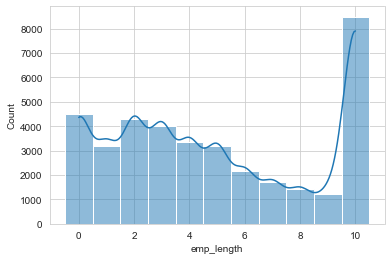

In [31]:
# Create histogram
sns.set_style("whitegrid")
sns.histplot(data=df, x='emp_length', kde=True, discrete=True)
plt.show()

If we set all null values to the median 4, let's check the distribution again to check we did not alter drastically the column.

In [32]:
# Set null values
emp_length_serie = df.emp_length.fillna(4)
emp_length_serie.describe()

count    38577.000000
mean         4.915779
std          3.512419
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64

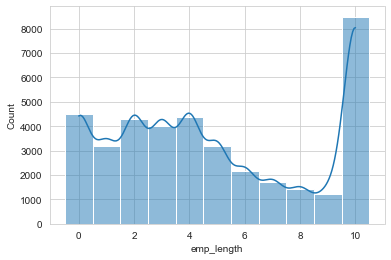

In [33]:
# Create histogram
sns.histplot(data=emp_length_serie, kde=True, discrete=True)
plt.show()

We can see that the mean and standard deviation were not heavily affected. On the histogram we can notice that the probability of value 4 has raised (which is expected). We'll go ahead with updating the values on the dataset "df".

In [34]:
# Fill emp_length null values with median
df.emp_length.fillna(4,inplace=True)

Earlier we could not change column type due to missing values, now we can correctly set it to type integer (int32).

In [35]:
df.emp_length = df.emp_length.astype(int)
df.emp_length.dtype

dtype('int32')

**revol_util column**

In the histogram we can see the distribution we set for bins = 10 (to check interest rate per ranges of size 10, as maximum value is near to 100 and minimum is zero). Most values are below 10% and the rest look like a normal distribution with mean and median around 50.

From below description we can see that the mean is 48.70 and the median is 49.10, the values are pretty close.

In [36]:
# Get column description
df.revol_util.describe()

count    38527.000000
mean        48.702777
std         28.364741
min          0.000000
25%         25.200000
50%         49.100000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64

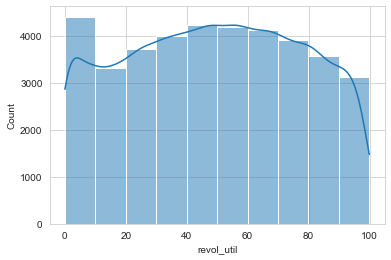

In [37]:
# Create histogram
sns.histplot(data=df, x='revol_util', kde=True, bins=10)
plt.show()

If we set all null values to 49.10, let's check the distribution again to check we did not alter drastically the column.

In [38]:
# Set null values
revol_util_serie = df.revol_util.fillna(49.10)
revol_util_serie.describe()

count    38577.000000
mean        48.703292
std         28.346356
min          0.000000
25%         25.200000
50%         49.100000
75%         72.200000
max         99.900000
Name: revol_util, dtype: float64

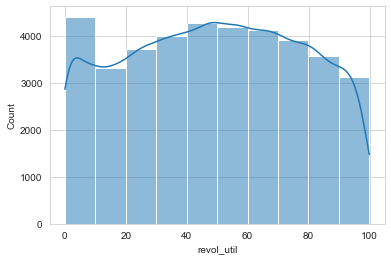

In [39]:
# Create histogram
sns.histplot(data=revol_util_serie, kde=True, bins=10)
plt.show()

We can see that the mean and standard deviation were not heavily affected. On the histogram we can notice that the probability of fifth bin has raised (which is expected). We'll go ahead with updating the values on the dataset "df".

In [40]:
# Fill revol_util null values with median
df.revol_util.fillna(49.10,inplace=True)

**pub_rec_bankruptcies column**

We know that most of the values for these column are zero, confirmed with below description and histogram.

In [41]:
# Get column description
df.pub_rec_bankruptcies.describe()

count    37880.000000
mean         0.043479
std          0.204583
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64

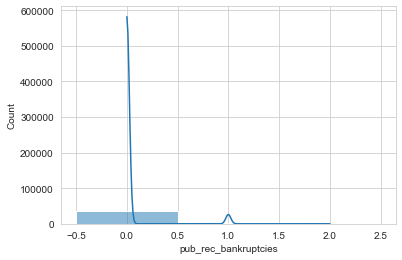

In [42]:
# Create histogram
sns.histplot(data=df, x='pub_rec_bankruptcies', kde=True, discrete=True)
plt.show()

If we set all null values to 0 (which will be 1.8% of total records in dataset), let's check the distribution again to check we did not alter drastically the column.

In [43]:
# Set null values
bankruptcies_serie = df.pub_rec_bankruptcies.fillna(0)
bankruptcies_serie.describe()

count    38577.000000
mean         0.042694
std          0.202809
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64

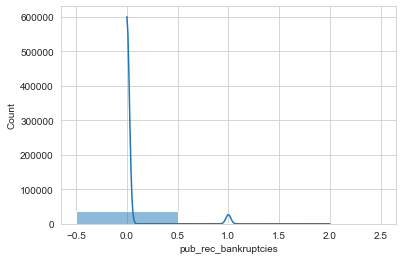

In [44]:
# Create histogram
sns.histplot(data=bankruptcies_serie, kde=True, discrete=True)
plt.show()

We can see that the mean and standard deviation were not heavily affected. On the histogram we can notice that the probability of value zero has raised but stays in the same count range. We'll go ahead with updating the values on the dataset "df".

In [45]:
# Fill revol_util null values with median
df.pub_rec_bankruptcies.fillna(0,inplace=True)

Earlier we could not change column type due to missing values, now we can correctly set it to type integer (int32).

In [46]:
df.pub_rec_bankruptcies = df.pub_rec_bankruptcies.astype(int)
df.pub_rec_bankruptcies.dtype

dtype('int32')

Let's check the null values again to be sure we covered all the cases.

In [47]:
# Print columns' missing values
df.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
dti                     0
delinq_2yrs             0
earliest_cr_line        0
inq_last_6mths          0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
pub_rec_bankruptcies    0
dtype: int64

### Data enrichment

With datetime variable, to simplify further analysis, we'll create the type-driven metrics year and month.

In [48]:
# Create earliest_cr_line year column
df['earliest_cr_line_year'] = pd.DatetimeIndex(df.earliest_cr_line).year

# Create earliest_cr_line month column
df['earliest_cr_line_month'] = pd.DatetimeIndex(df.earliest_cr_line).month

For interest rate analysis we'll create a categorical column from it with values Low, Medium, and High.

**Note:** the ranges were decided after reviewing the behaviour in "Data Analysis" section, based on percentiles for Fully Paid loans.

In [49]:
# Interest rates for defaulted loans (categorized)
df['int_rate_cat'] = df.int_rate.apply(lambda x: 'Low' if x <= 8.00 else ('Medium' if x <= 13.79 else 'High'))

For revol_util analysis we'll create a categorical column from it with values Low, Medium, and High.

**Note:** the ranges were decided after reviewing the behaviour in "Data Analysis" section, based on percentiles for Fully Paid loans.

In [50]:
# revol_util for defaulted loans (categorized)
df['revol_util_cat'] = df.revol_util.apply(lambda x: 'Low' if x <= 23.2 else ('Medium' if x <= 69.6 else 'High'))

Let's take a look at the data set information to check we have the correct column types.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   loan_amnt               38577 non-null  int64         
 1   term                    38577 non-null  object        
 2   int_rate                38577 non-null  float64       
 3   installment             38577 non-null  float64       
 4   grade                   38577 non-null  object        
 5   emp_length              38577 non-null  int32         
 6   home_ownership          38577 non-null  object        
 7   annual_inc              38577 non-null  float64       
 8   verification_status     38577 non-null  object        
 9   loan_status             38577 non-null  object        
 10  purpose                 38577 non-null  object        
 11  dti                     38577 non-null  float64       
 12  delinq_2yrs             38577 non-null  int64 

So far we have **5 columns and 38,577 rows**.

## Data analysis

### Handling outliers

Let's create a pair plot to compare continuous quantitative variables behaviour and determine where we can find strong relationships and outliers.

Continuous quantitative variables are:
- annual_inc
- dti
- int_rate
- installment
- loan_amnt
- revol_bal
- revol_util

In [52]:
# Dataframe with quantitative variables only
df_quant = df[['annual_inc','dti','int_rate','installment','loan_amnt','revol_bal','revol_util']]

From below pairplot we see that for almost all continuous quantitative variables there is no clear trend (distribution), except for the **relationship between loan_amnt and installment**. This relationship is clearly positive and expected as the higher the loan amount, the higher the scheduled payments to settle.

**For annual income we see the most outliers** in relationships with the other variables, we need to clean annual_inc outliers first.

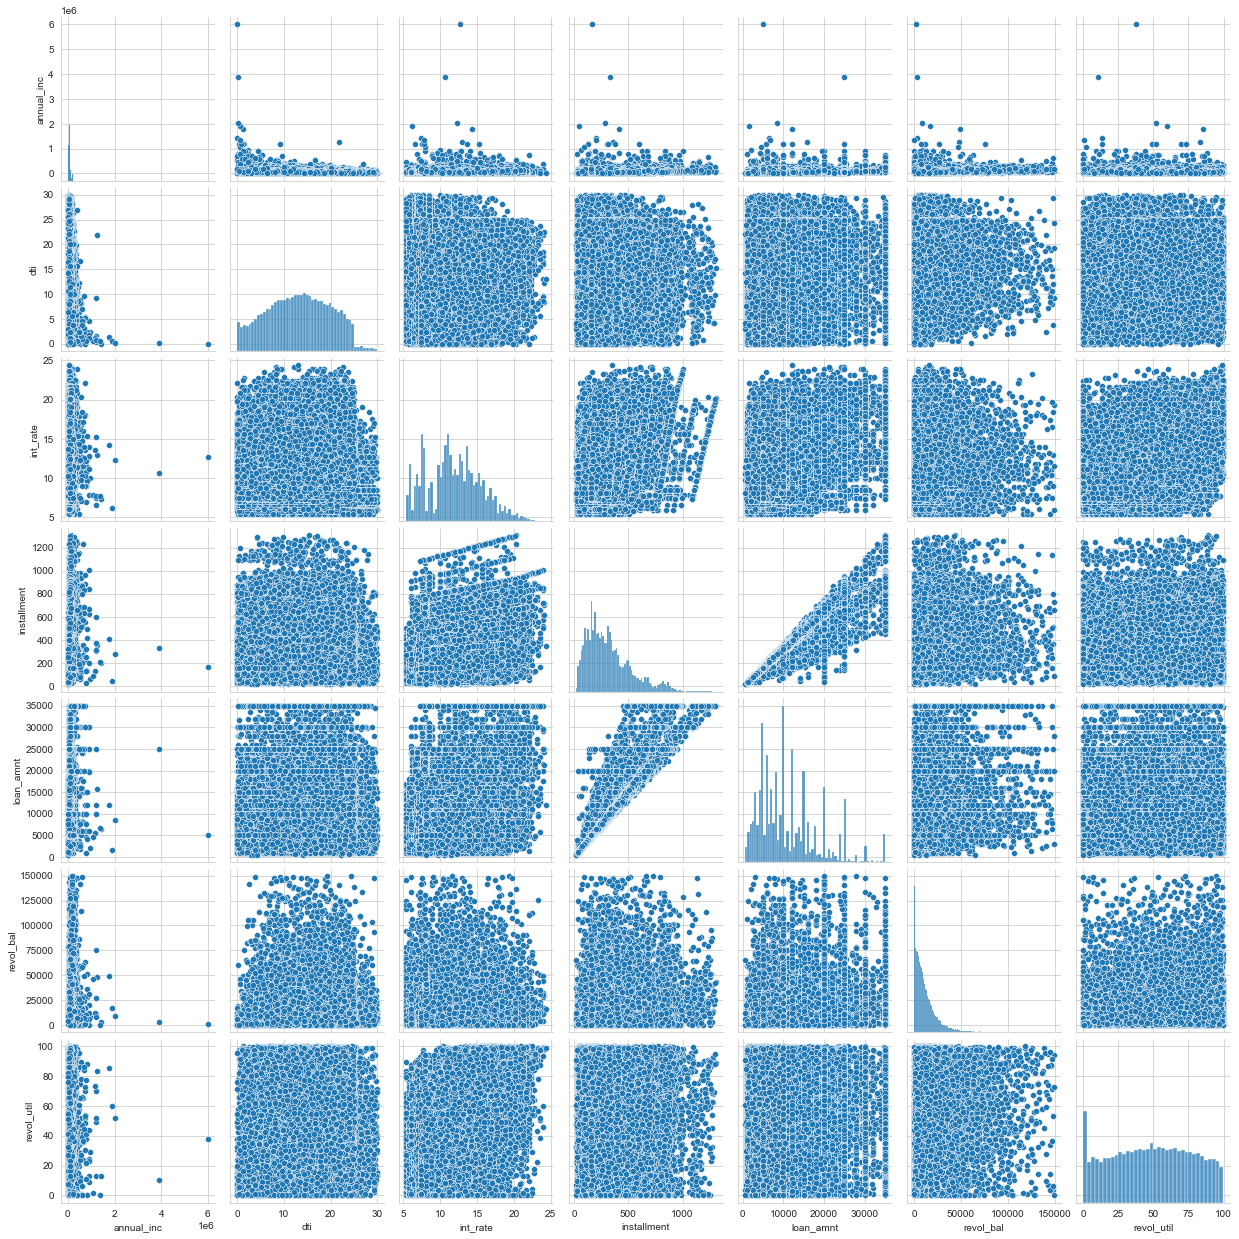

In [53]:
# Create pairplot
sns.pairplot(data=df_quant)
plt.show()

**annual_inc column**

With the column description below we can see that 75% of the data is between 4,000 and 82,000.

In [54]:
# Check value counts
df.annual_inc.describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

Maximum value stands out from the rest, we can review the distribution with a histogram and a box plot to decide which values represent outliers.

From below plots we can tell that histogram is heavily skewed with 75% of data between 4,000 and 145,000 (upper fence). Around 4.57% of the data is above that, which is a high volume of data.

In [55]:
# Get values greater than upper fence
gr_upper = df[df.annual_inc>145000].shape[0]
print('Values greater than upper fence: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than upper fence:  1762
Percentage of total:  4.57 %


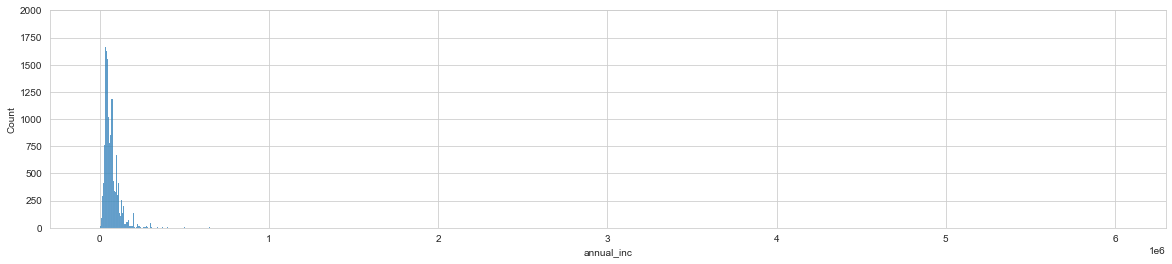

In [56]:
# Create a histogram
plt.figure(figsize=[20,4])
sns.histplot(df.annual_inc)
plt.show()

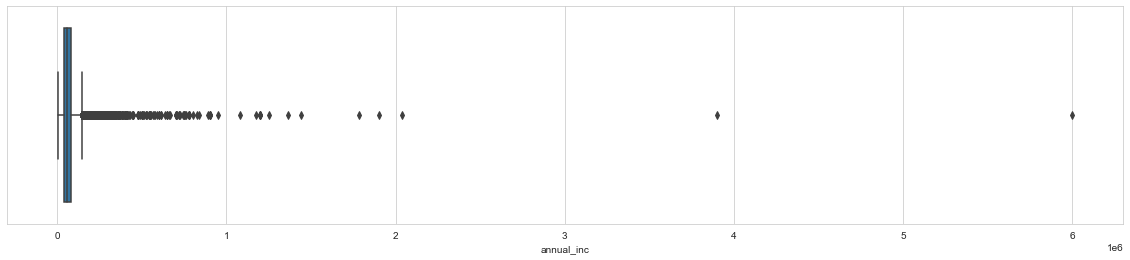

In [57]:
# Create a boxplot
plt.figure(figsize=[20,4])
sns.boxplot(df.annual_inc)
plt.show()

If we take a look at the count of loans by status for annual incomes greater than upper fence, we can see that defaulted loans represent a small value compared to paid ones, and might not affect final analysis as we want indicator of default.

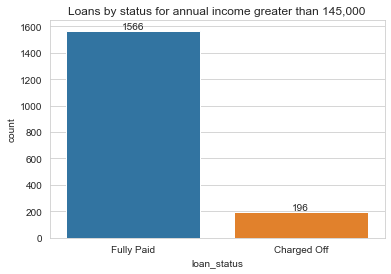

In [58]:
temp_high = df[df.annual_inc>145000]

# Count loans by loan_status
plt.figure(figsize=[6,4])
ax = sns.countplot(x='loan_status', data=temp_high)
ax.bar_label(ax.containers[0])
ax.set(title='Loans by status for annual income greater than 145,000')
plt.show()

**We will drop values greater than 145,000**.

In [59]:
# Drop defined values for annual_inc
df = df[df.annual_inc <= 145000]

In [60]:
df.shape

(36815, 25)

After removing annual_inc outliers **we have 36,815 rows; we removed 4.56% of data**.

Let's review again the pair plot. We can see a wider distribution of values now in all relationships with annual_inc variable.

**For revol_bal we see the most outliers now** in relationships with the other variables, we need to clean revol_bal outliers then.

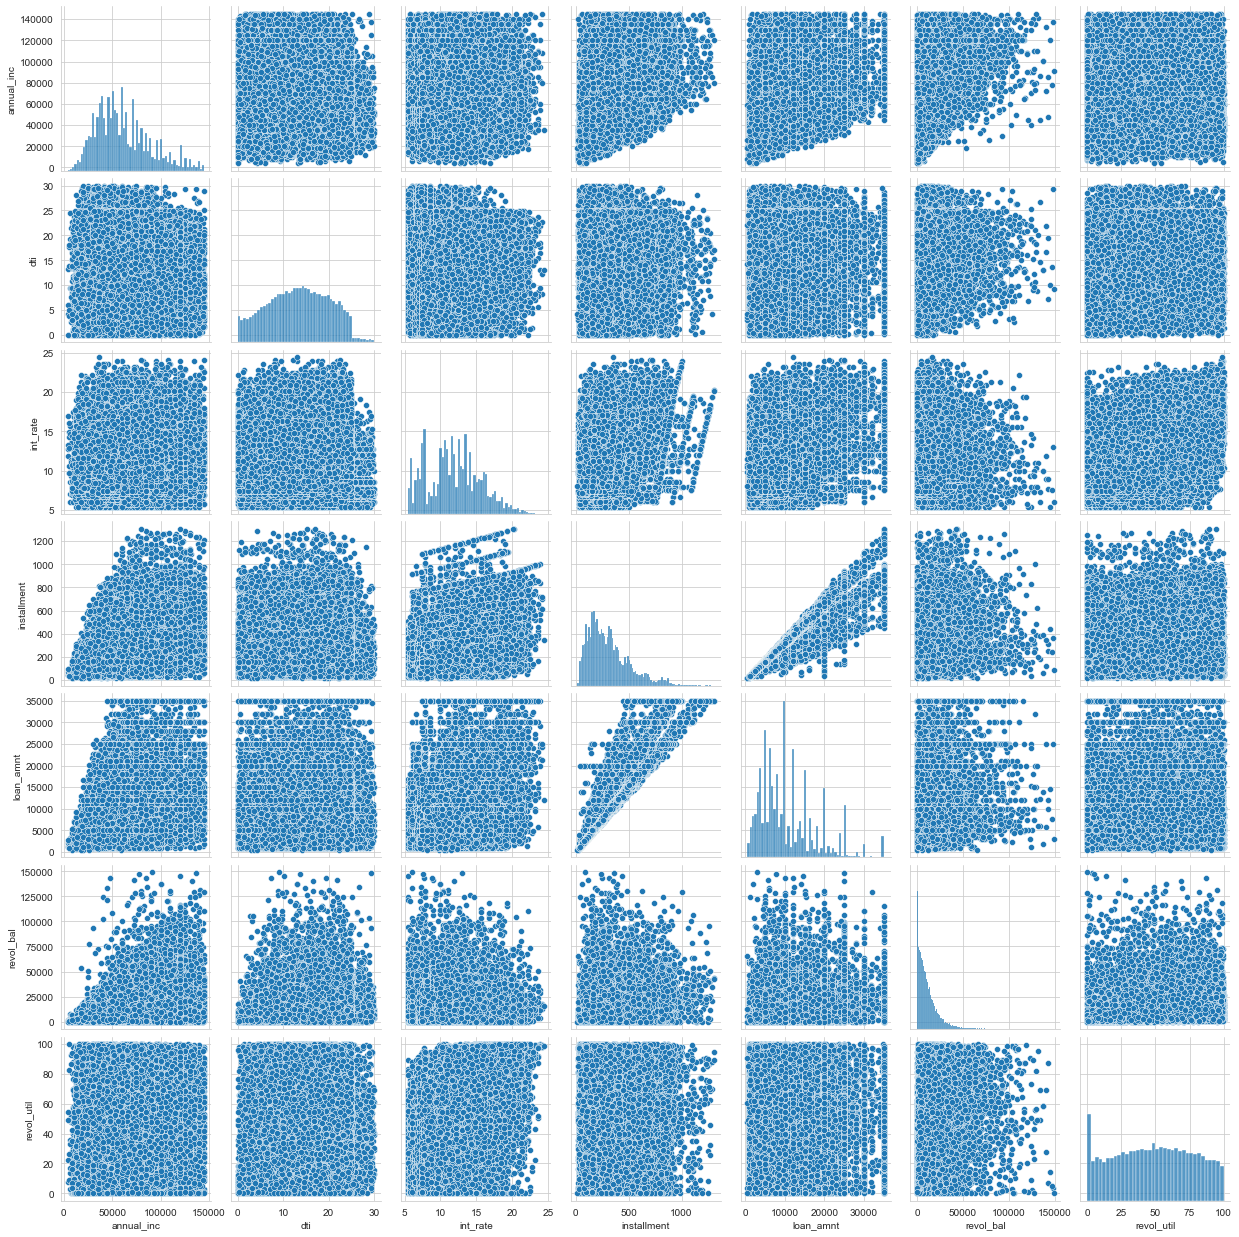

In [61]:
# Dataframe with quantitative variables only
df_quant = df[['annual_inc','dti','int_rate','installment','loan_amnt','revol_bal','revol_util']]

# Create pairplot
sns.pairplot(data=df_quant)
plt.show()

**revol_bal column**


With the column description below we can see that 75% of the data is between 0 and 16,212.

In [62]:
# Get column description
df.revol_bal.describe()

count     36815.000000
mean      12369.150564
std       13858.072664
min           0.000000
25%        3565.500000
50%        8522.000000
75%       16212.000000
max      149000.000000
Name: revol_bal, dtype: float64

We can review the distribution with a histogram and a box plot to decide if maximum value represents an outlier.

From below plots we can tell that most of the data is between 0 and 28,857 (upper fence). Around 8.64% of the data is above that (an important amount).

In [63]:
# Get values greater than upper fence
gr_upper = df[df.revol_bal>28857].shape[0]
print('Values greater than upper fence: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than upper fence:  3180
Percentage of total:  8.64 %


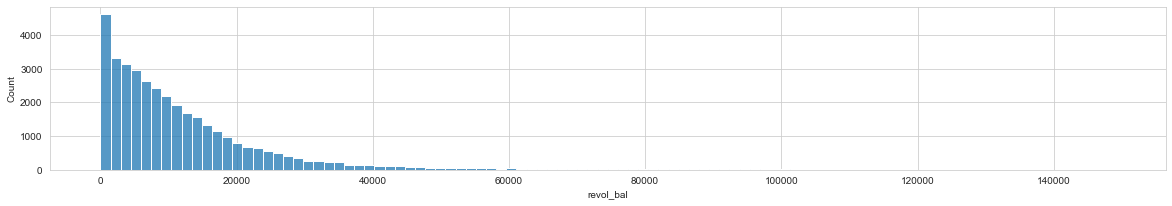

In [64]:
# Create a histogram
plt.figure(figsize=[20,3])
sns.histplot(df.revol_bal, bins=100)
plt.show()

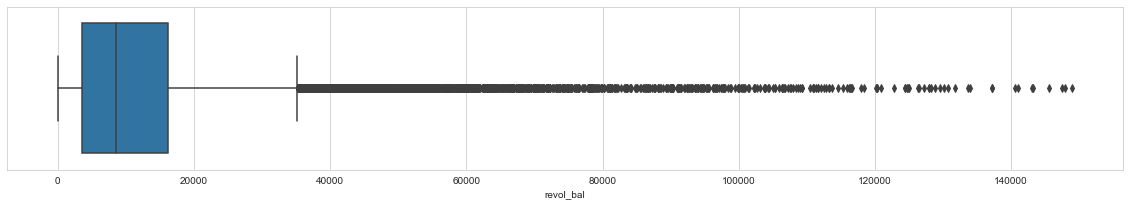

In [65]:
# Create a boxplot
plt.figure(figsize=[20,3])
sns.boxplot(df.revol_bal)
plt.show()

If we take a look at the count of loans by status for revol_bal greater than upper fence, we can see that defaulted loans represent a small value compared to paid ones, and might not affect final analysis as we want indicator of default.

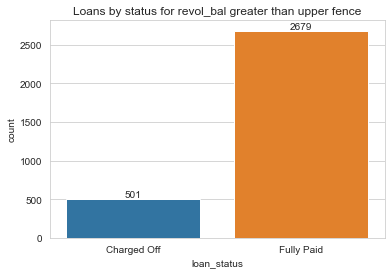

In [66]:
temp_high = df[df.revol_bal>28857]

# Count loans by loan_status
plt.figure(figsize=[6,4])
ax = sns.countplot(x='loan_status', data=temp_high)
ax.bar_label(ax.containers[0])
ax.set(title='Loans by status for revol_bal greater than upper fence')
plt.show()

**We will remove values with revol_bal greater than 28,857**.

In [67]:
# Drop defined values for revol_bal
df = df[df.revol_bal <= 28857]

In [68]:
df.shape

(33635, 25)

After removing revol_bal outliers **we have 33,635 rows; we removed 8.64% of data**.

Let's review again the pair plot.

**For installment we see the most outliers now** in relationships with the other variables, and it is highly related to loan_amnt. Let's clean installment outliers.

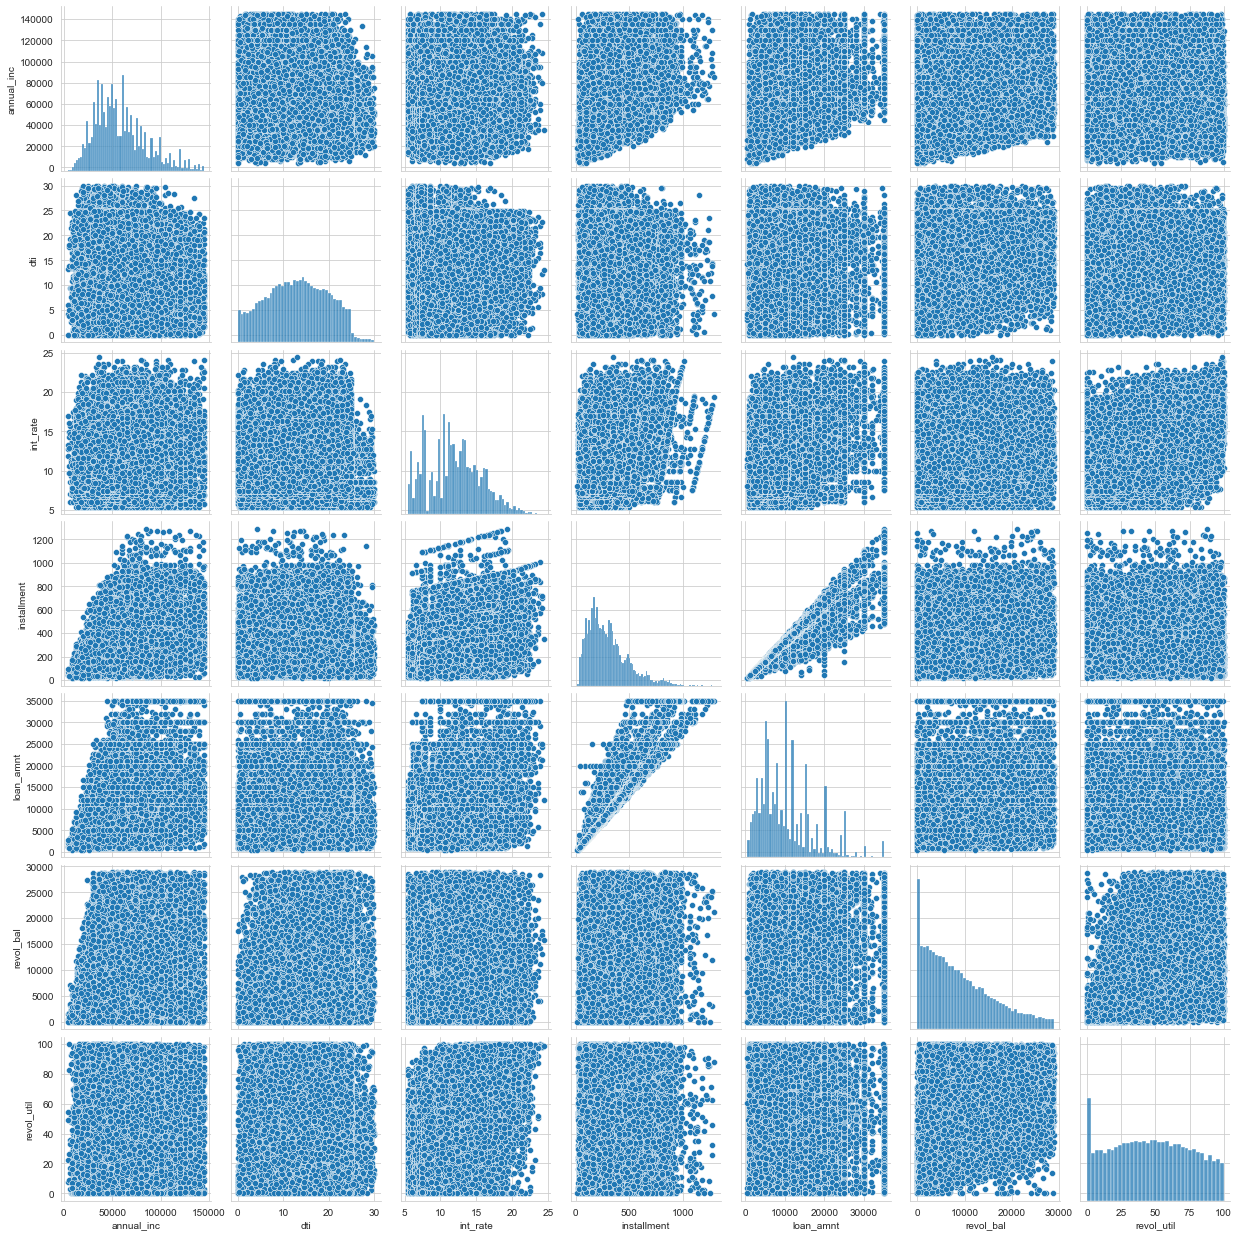

In [69]:
# Dataframe with quantitative variables only
df_quant = df[['annual_inc','dti','int_rate','installment','loan_amnt','revol_bal','revol_util']]

# Create pairplot
sns.pairplot(data=df_quant)
plt.show()

**installment column**

With the column description below we can see that 75% of the data is between 15.69 and 395.66.

In [70]:
# Check value counts
df.installment.describe()

count    33635.000000
mean       301.003729
std        189.894666
min         15.690000
25%        159.870000
50%        262.110000
75%        395.660000
max       1288.100000
Name: installment, dtype: float64

We can review the distribution with a histogram and a box plot to decide if maximum value represents an outlier.

From below plots we can tell that most of the data is between 0 and 749.345 (upper fence). We have 3.31% of the data is above that.

In [71]:
# Get values greater than upper fence
gr_upper = df[df.installment>749.345].shape[0]
print('Values greater than upper fence: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than upper fence:  1112
Percentage of total:  3.31 %


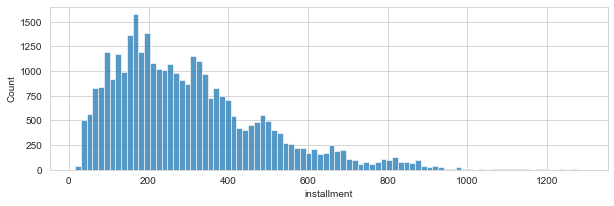

In [72]:
# Create a histogram
plt.figure(figsize=[10,3])
sns.histplot(df.installment)
plt.show()

If we take a look at the count of loans by status for installment greater than upper fence, we can see that defaulted loans represent a small value compared to paid ones, and might not affect final analysis as we want indicator of default.

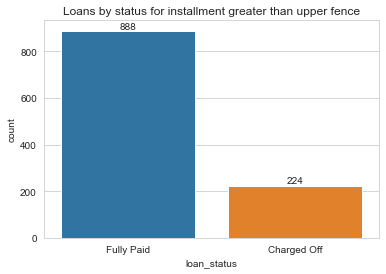

In [73]:
temp_high = df[df.installment>749.345]

# Count loans by loan_status
plt.figure(figsize=[6,4])
ax = sns.countplot(x='loan_status', data=temp_high)
ax.bar_label(ax.containers[0])
ax.set(title='Loans by status for installment greater than upper fence')
plt.show()

**We will remove values greater than 749.345**.

In [74]:
# Drop defined values for revol_bal
df = df[df.installment <= 749.345]

In [75]:
df.shape

(32523, 25)

After removing installment outliers **we have 32,523 rows; we removed 3.30% of data**.

Let's review again the pairplot.

**For loan_amnt we see the most outliers now** in relationships with the other variables, we need to clean loan_amnt outliers then.

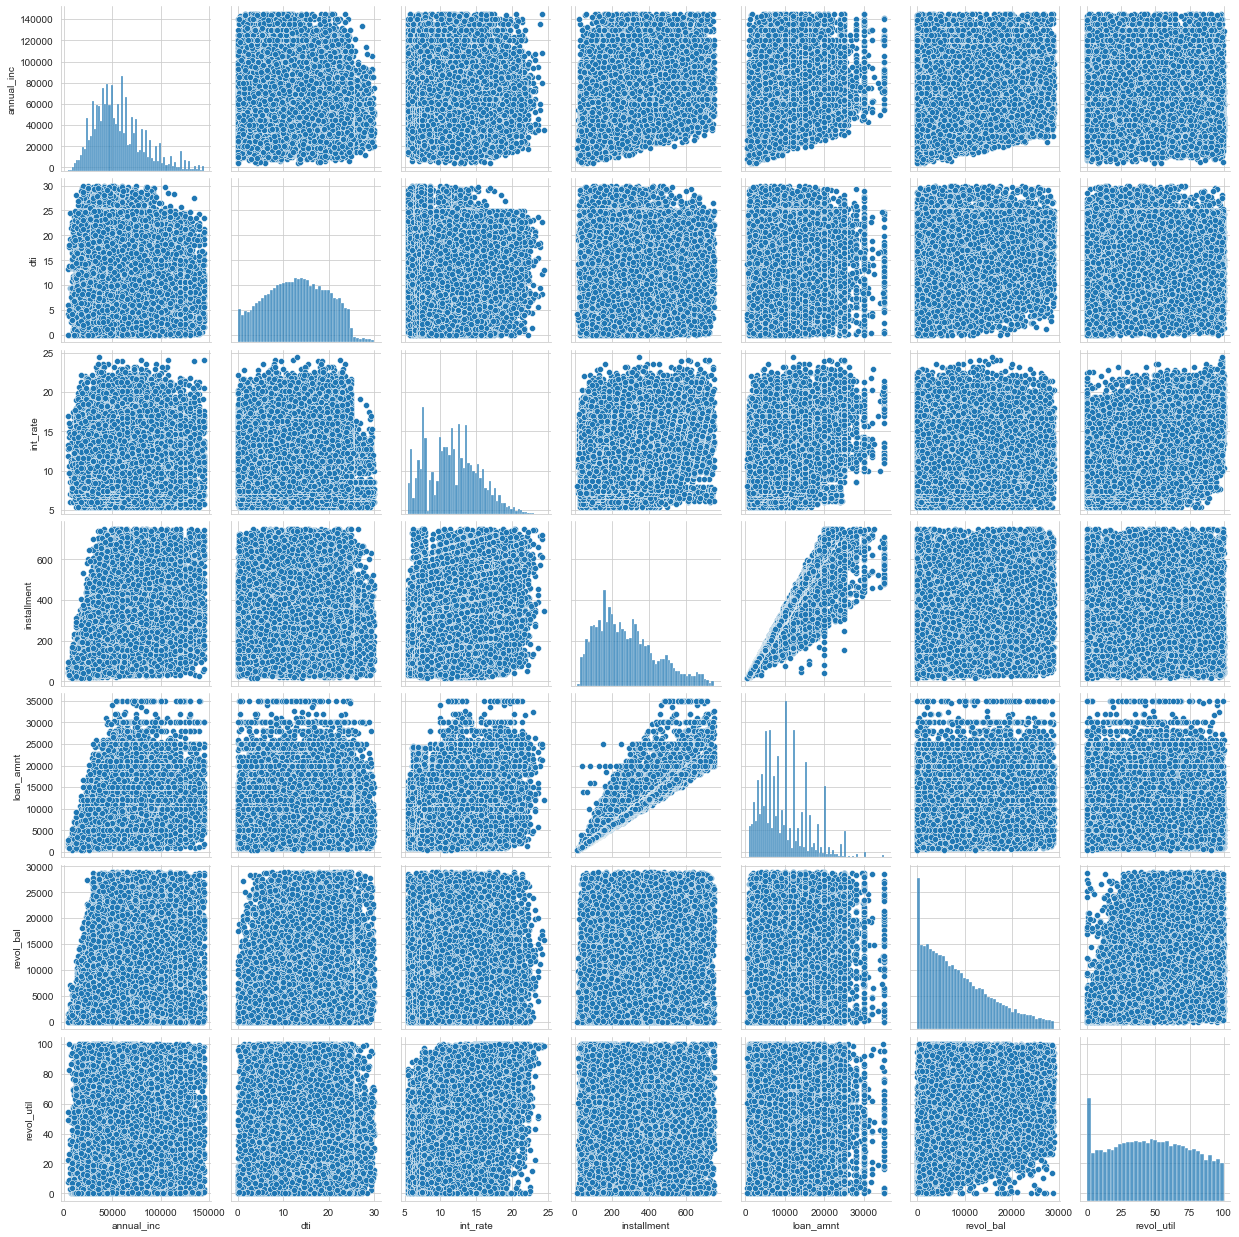

In [76]:
# Dataframe with quantitative variables only
df_quant = df[['annual_inc','dti','int_rate','installment','loan_amnt','revol_bal','revol_util']]

# Create pairplot
sns.pairplot(data=df_quant)
plt.show()

**loan_amnt column**

With the column description below we can see that 75% of the data is between 500 and 13,000.

In [77]:
# Get column description
df.loan_amnt.describe()

count    32523.000000
mean      9671.277250
std       5922.635977
min        500.000000
25%       5000.000000
50%       8400.000000
75%      13000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

We can review the distribution with a histogram and a box plot to decide if maximum value represents an outlier.

From below plots we can tell that most of the data is between 500 and 25,000 (upper fence). Around 0.98% of the data is above that.

In [78]:
# Get values greater than upper fence
gr_upper = df[df.loan_amnt>25000].shape[0]
print('Values greater than upper fence: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than upper fence:  319
Percentage of total:  0.98 %


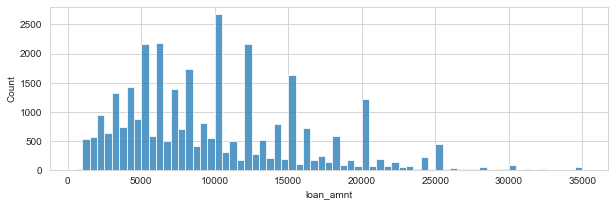

In [79]:
# Create a histogram
plt.figure(figsize=[10,3])
sns.histplot(df.loan_amnt)
plt.show()

If we take a look at the count of loans by status for loan_amnt greater than upper fence, we can see that defaulted loans represent a small value compared to paid ones, and might not affect final analysis as we want indicator of default.

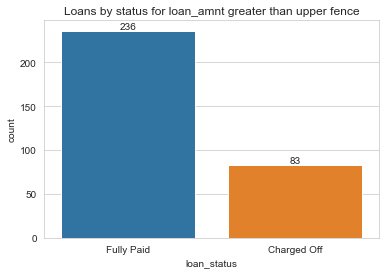

In [80]:
temp_high = df[df.loan_amnt>25000]

# Count loans by loan_status
plt.figure(figsize=[6,4])
ax = sns.countplot(x='loan_status', data=temp_high)
ax.bar_label(ax.containers[0])
ax.set(title='Loans by status for loan_amnt greater than upper fence')
plt.show()

**We will remove values greater than 25,000**.

In [81]:
# Drop defined values for revol_bal
df = df[df.loan_amnt <= 25000]

In [82]:
df.shape

(32204, 25)

After removing loan_amnt outliers **we have 32,204 rows; we removed 0.98% of data**.

In scatter plot there would be some outliers in general, but we'll leave them like this for analysis.

Now let's review the rest of the quantitative variables for detecting outliers, many of them non-continuous quantitative ones.

**delinq_2yrs column**

With the column value counts below we can see that most of the values are zero (88.92% of the total).

In [83]:
# Get column description
df.delinq_2yrs.value_counts()

0     28639
1      2730
2       560
3       185
4        53
5        19
6        10
7         4
8         2
9         1
11        1
Name: delinq_2yrs, dtype: int64

We can review the distribution with a histogram to decide which values represent outliers.

From below plot we can tell that most of the data is between 0 and 3. We have 0.28% of the data above that, not representative. **We will drop values greater than 3**.

In [84]:
# Get values greater than upper fence
gr_upper = df[df.delinq_2yrs>3].shape[0]
print('Values greater than 3: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than 3:  90
Percentage of total:  0.28 %


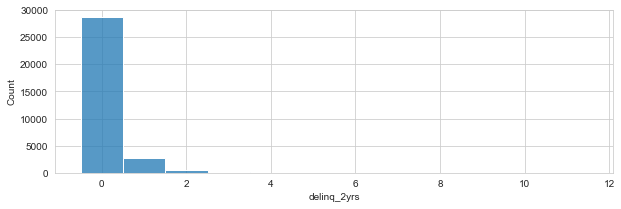

In [85]:
# Create a histogram
plt.figure(figsize=[10,3])
sns.histplot(df.delinq_2yrs, discrete=True)
plt.show()

**dti column**

With the column description below we can see that 75% of the data is between 0 and 18.38.

In [86]:
# Check value counts
df.dti.describe()

count    32204.000000
mean        13.108703
std          6.668239
min          0.000000
25%          7.950000
50%         13.150000
75%         18.380000
max         29.990000
Name: dti, dtype: float64

We can review the distribution with a histogram and a box plot to decide if maximum value represents an outlier.

From below plots we can tell that most of the data is between 0 and 30, with no outliers. **We don't need to remove values in this case**.

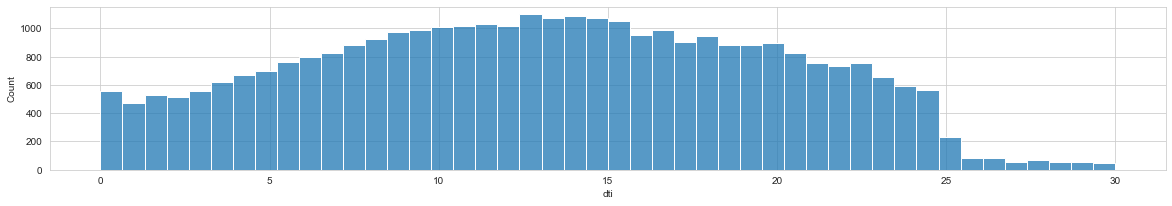

In [87]:
# Create a histogram
plt.figure(figsize=[20,3])
sns.histplot(df.dti)
plt.show()

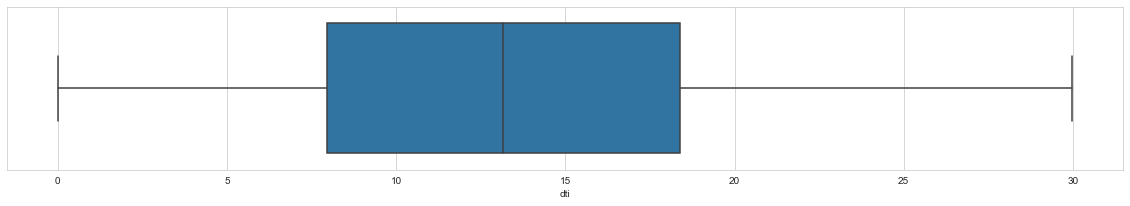

In [88]:
# Create a boxplot
plt.figure(figsize=[20,3])
sns.boxplot(df.dti)
plt.show()

**inq_last_6mths column**

With the column value counts below we can see that most of the values are zero or one (76.36% of the total).

In [89]:
# Get column description
df.inq_last_6mths.value_counts()

0    15667
1     8927
2     4694
3     2477
4      244
5      118
6       43
7       26
8        8
Name: inq_last_6mths, dtype: int64

We can review the distribution with a histogram to decide which values represent outliers.

From below plot we can tell that most of the data is between 0 and 3. We have 1.37% of the data above that.

In [90]:
# Get values greater than upper fence
gr_upper = df[df.inq_last_6mths>3].shape[0]
print('Values greater than 3: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than 3:  439
Percentage of total:  1.36 %


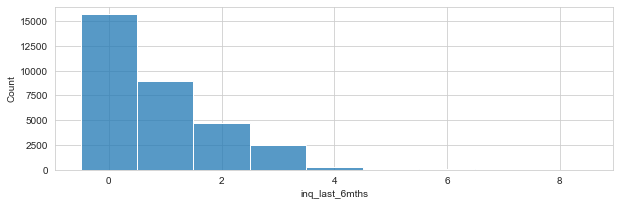

In [91]:
# Create a histogram
plt.figure(figsize=[10,3])
sns.histplot(df.inq_last_6mths, discrete=True)
plt.show()

If we take a look at the count of loans by status for inquiries greater than 3, we can see that defaulted loans represent a small value compared to paid ones, and might not affect final analysis as we want indicator of default.

**We will drop values greater than 3**.

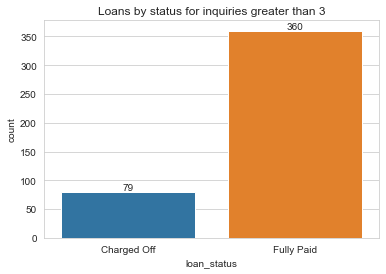

In [92]:
temp_high = df[df.inq_last_6mths>3]

# Count loans by loan_status
plt.figure(figsize=[6,4])
ax = sns.countplot(x='loan_status', data=temp_high)
ax.bar_label(ax.containers[0])
ax.set(title='Loans by status for inquiries greater than 3')
plt.show()

**int_rate column**

With the column description below we can see that 75% of the data is between 5.42% and 14.18%.

In [93]:
# Check value counts
df.int_rate.describe()

count    32204.000000
mean        11.718735
std          3.603269
min          5.420000
25%          8.880000
50%         11.490000
75%         14.180000
max         24.400000
Name: int_rate, dtype: float64

We can review the distribution with a histogram or a box plot to decide if maximum value represents an outlier.

From below plots we can tell that most of the data is between 5.42 and 22.13 (upper fence). Around 0.16% of the data is above that. **We will remove values greater than 22.13**.

In [94]:
# Get values greater than upper fence
gr_upper = df[df.int_rate>22.13].shape[0]
print('Values greater than upper fence: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than upper fence:  50
Percentage of total:  0.16 %


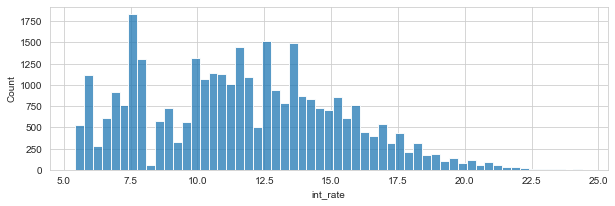

In [95]:
# Create a histogram
plt.figure(figsize=[10,3])
sns.histplot(df.int_rate)
plt.show()

**open_acc column**

With the column description below we can see that 75% of the data is between 2 and 11.

In [96]:
# Get column description
df.open_acc.describe()

count    32204.000000
mean         8.892653
std          4.267344
min          2.000000
25%          6.000000
50%          8.000000
75%         11.000000
max         42.000000
Name: open_acc, dtype: float64

We can review the distribution with a histogram and a box plot to decide if maximum value represents an outlier.

From below plots we can tell that most of the data is between 2 and 18.5 (upper fence). Around 2.95% of the data is above that (an important amount), but in histogram we can still define values around '25' (greater than that we have 0.28% of data),  **we can drop values greater than 25**.

In [97]:
# Get values greater than upper fence
gr_upper = df[df.open_acc>25].shape[0]
print('Values greater than 25: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than 25:  90
Percentage of total:  0.28 %


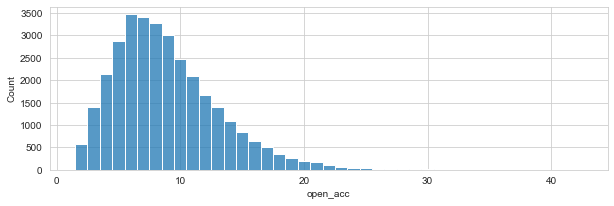

In [98]:
# Create a histogram
plt.figure(figsize=[10,3])
sns.histplot(df.open_acc, discrete=True)
plt.show()

**pub_rec column**

With the column value counts below we can see that most of the values are zero (94.05% of total).

In [99]:
# Get column value counts
df.pub_rec.value_counts()

0    30289
1     1862
2       45
3        6
4        2
Name: pub_rec, dtype: int64

From below percentage we can tell that around 0.15% of the data is above value one, **we can drop values greater than 1**.

In [100]:
# Get values greater than upper fence
gr_upper = df[df.pub_rec>1].shape[0]
print('Values greater than 1: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than 1:  53
Percentage of total:  0.16 %


**pub_rec_bankruptcies column**

With the column value counts below we can see that most of the values are zero (95.29% of total).

In [101]:
# Get column value counts
df.pub_rec_bankruptcies.value_counts()

0    30689
1     1510
2        5
Name: pub_rec_bankruptcies, dtype: int64

From below percentage we can tell that around 0.02% of the data is above value one, **we can drop values greater than 1**.

In [102]:
# Get values greater than upper fence
gr_upper = df[df.pub_rec_bankruptcies>1].shape[0]
print('Values greater than 1: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than 1:  5
Percentage of total:  0.02 %


**revol_util column**


With the column description below we can see that 75% of the data is between 0 and 70.4.

In [103]:
# Get column description
df.revol_util.describe()

count    32204.000000
mean        47.260951
std         28.224066
min          0.000000
25%         23.900000
50%         47.000000
75%         70.400000
max         99.900000
Name: revol_util, dtype: float64

**We don't need to remove values in this case** as the variable is a percentage with values from zero to 99.9 (almost 100).

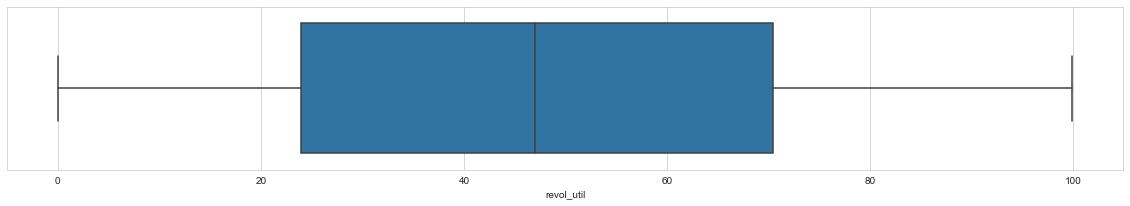

In [104]:
# Create a boxplot
plt.figure(figsize=[20,3])
sns.boxplot(df.revol_util)
plt.show()

**total_acc column**

With the column description below we can see that 75% of the data is between 2 and 27.

In [105]:
df.total_acc.describe()

count    32204.000000
mean        20.695473
std         10.926505
min          2.000000
25%         13.000000
50%         19.000000
75%         27.000000
max         90.000000
Name: total_acc, dtype: float64

We can review the distribution with a histogram and a box plot to decide if maximum value represents an outlier.

From below plots we can tell that most of the data is between 2 and 48 (upper fence). Around 1.98% of the data is above that, **we will drop values greater than 48**.

In [106]:
# Get values greater than upper fence
gr_upper = df[df.total_acc>48].shape[0]
print('Values greater than upper fence: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than upper fence:  639
Percentage of total:  1.98 %


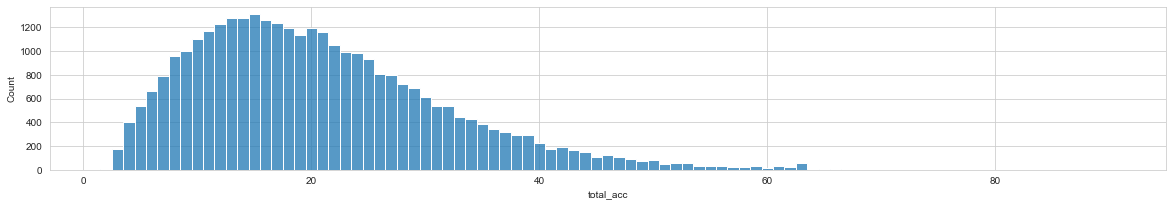

In [107]:
# Create a histogram
plt.figure(figsize=[20,3])
sns.histplot(df.total_acc, discrete = True)
plt.show()

**After individual analysis** we will drop values for following columns:
- delinq_2yrs: values greater than 3
- inq_last_6mths: values greater than 3
- int_rate: values greater than 22.23
- open_acc: values greater than 25
- pub_rec & pub_rec_bankruptcies: values greater than 1
- total acc: values greater than 48

In [108]:
# Drop defined values for delinq_2yrs
df = df[df.delinq_2yrs <= 3]

# Drop defined values for inq_last_6mths
df = df[df.inq_last_6mths <= 3]

# Drop defined values for int_rate
df = df[df.int_rate <= 22.23]

# Drop defined values for open_acc
df = df[df.open_acc <= 25]

# Drop defined values for pub_rec
df = df[df.pub_rec <= 1]

# Drop defined values for pub_rec_bankruptcies
df = df[df.pub_rec_bankruptcies <= 1]

# Drop defined values for total acc
df = df[df.total_acc <= 48]

In [109]:
df.shape

(30925, 25)

**After removing outliers we have 30,925 rows**, 3.97% of data was dropped.

### Loan status distribution

In the plot below we can see the distribution of the loans by status. "Fully Paid" loans represent 85.69% of the data, and **"Charged Off" loans the remaining 14.31%**.

Lending Club, according to this dataset, has done a good job selecting their borrowers, but we want to take a closer look into defaulted loans and get the indicator of default.

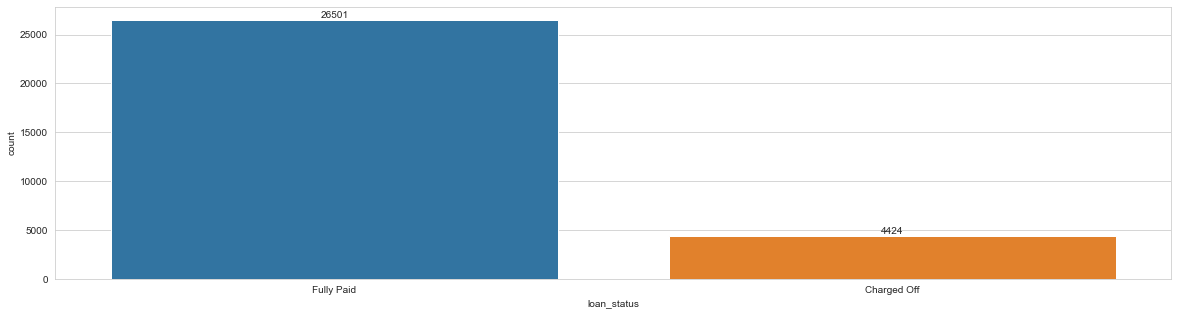

In [110]:
# Count loans by loan_status
plt.figure(figsize=[20,5])
ax = sns.countplot(x='loan_status', data=df)
ax.bar_label(ax.containers[0])
plt.show()

### Categorical variables review
We'll review their distribution by loan status (Fully Paid, Charged Off).

For **earliest_cr_line column** let's review the distribution of loans per year.

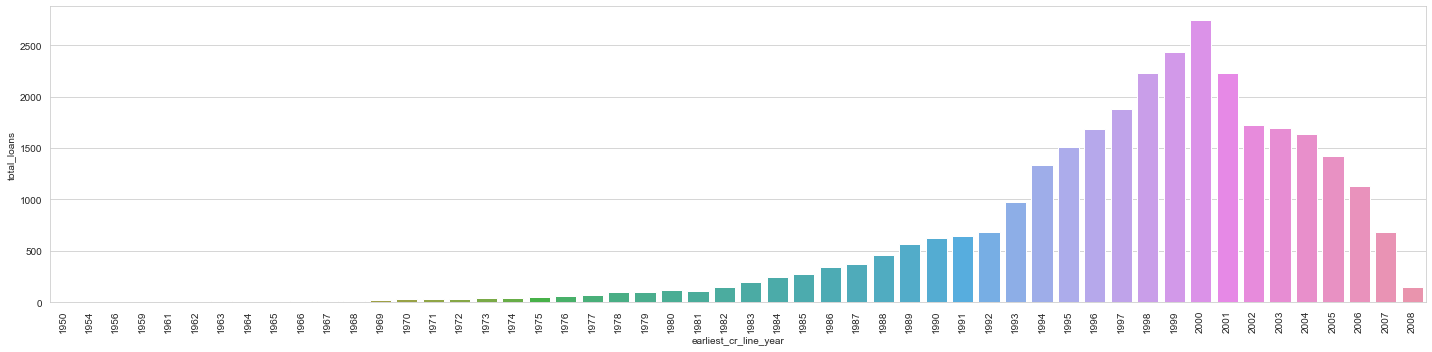

In [111]:
# Count loans by year
earliest_year = pd.pivot_table(df, index='earliest_cr_line_year', values='loan_status', aggfunc='count')

plt.figure(figsize=[20,5])
ax = sns.barplot(data=earliest_year, x=earliest_year.index, y='loan_status')
plt.xticks(rotation=90)
plt.tight_layout()
ax.set(ylabel='total_loans')
plt.show()

We do not get meaningful information from this at it shows the year the borrower first requested a credit line, so let's look at aggregation by month.

We can clearly see that towards the end of the year and in January the total loans requests increase. Most likely, it is due to the **expenses that are made at the end of the year and the debts accumulated throughout the year**, which must be settled. 

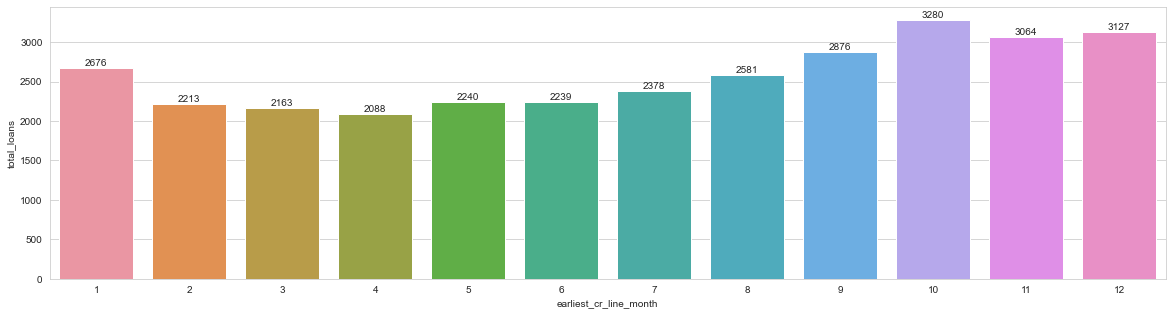

In [112]:
# Count loans by month
earliest_month = pd.pivot_table(df, index='earliest_cr_line_month', values='loan_status', aggfunc='count')

plt.figure(figsize=[20,5])
ax = sns.barplot(data=earliest_month, x=earliest_month.index, y='loan_status')
ax.bar_label(ax.containers[0])
ax.set(ylabel='total_loans')
plt.show()

Now let's review by month and loan status in chart below. **Loans categorized as "Charged Off" seem to remain in the same range independently of the month**, having the maximum value in December.

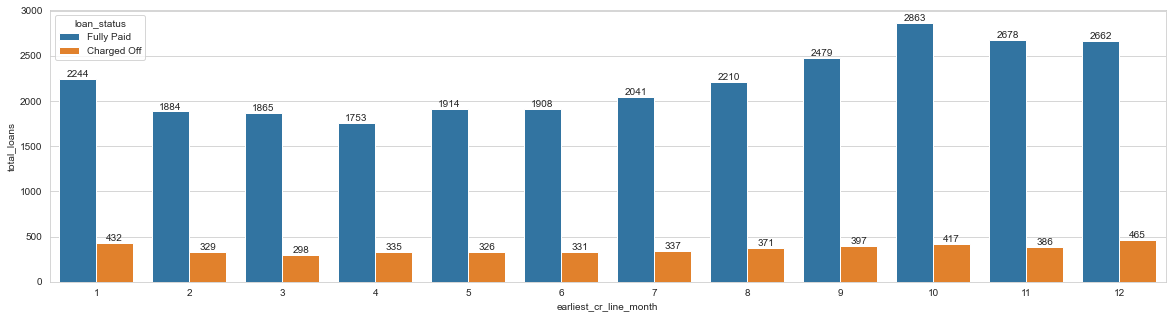

In [113]:
# Count loans grouped by month and status
plt.figure(figsize=[20,5])
ax = sns.countplot(x='earliest_cr_line_month', hue="loan_status", data=df)
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

For **emp_length column** let's review the distribution of loans.

People that has been **employed for more than 10 years are the ones who mostly request loans and end up in default**. Just for curiosity: Could this indicate that the greater your age the greater your debts?


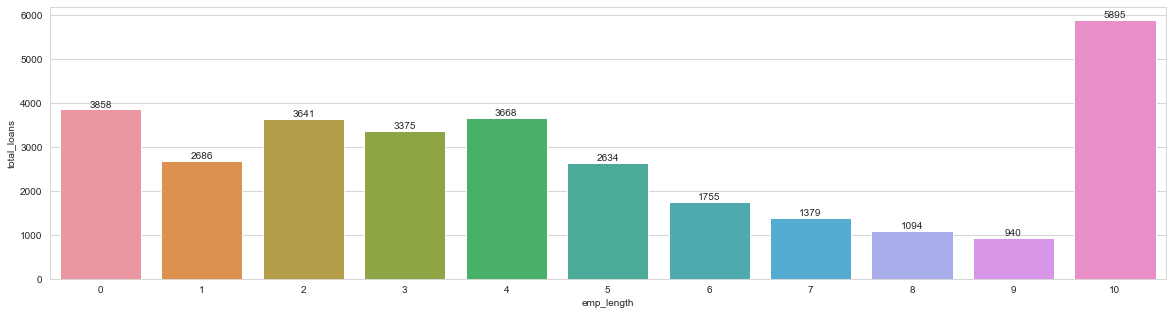

In [114]:
# Count loans by employment length
emp_length = pd.pivot_table(df, index='emp_length', values='loan_status', aggfunc='count')

plt.figure(figsize=[20,5])
ax = sns.barplot(data=emp_length, x=emp_length.index, y='loan_status')
ax.bar_label(ax.containers[0])
ax.set(ylabel='total_loans')
plt.show()

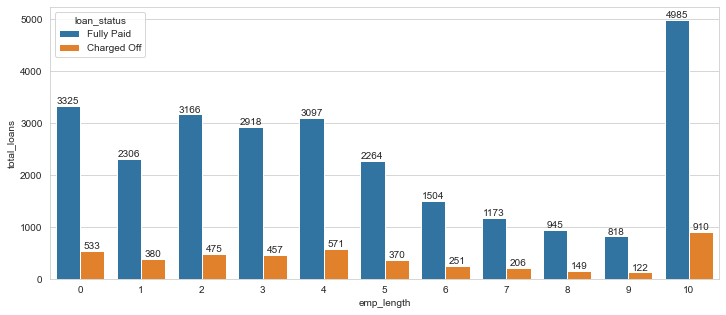

In [115]:
# Count loans grouped by purpose and status
plt.figure(figsize=[12,5])
ax = sns.countplot(x='emp_length', hue="loan_status", data=df)
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

People that has been **employed for more than 10 years is requesting more than other types loans for debt_consolidation** (but we cannot conclude from this that the greater your age the greater your debts...).

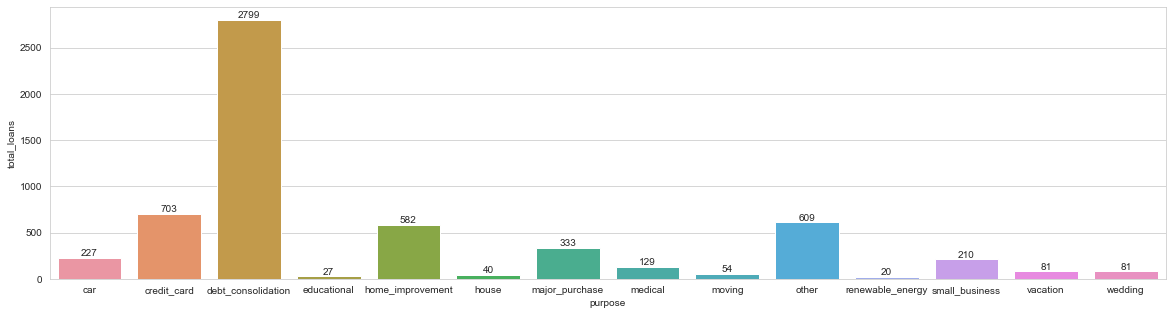

In [116]:
# Loans for people employed for more than 10 years
df_ten = df[df.emp_length==10]

# Count loans by purpose for people employed for more than 10 years
purpose_ten = pd.pivot_table(df_ten, index='purpose', values='loan_status', aggfunc='count')

plt.figure(figsize=[20,5])
ax = sns.barplot(data=purpose_ten, x=purpose_ten.index, y='loan_status')
ax.bar_label(ax.containers[0])
ax.set(ylabel='total_loans')
plt.show()

For **purpose column** we can see that by status "debt_consolidation" has the maximum value, and the category also includes the maximum value for "Charged Off" loans.

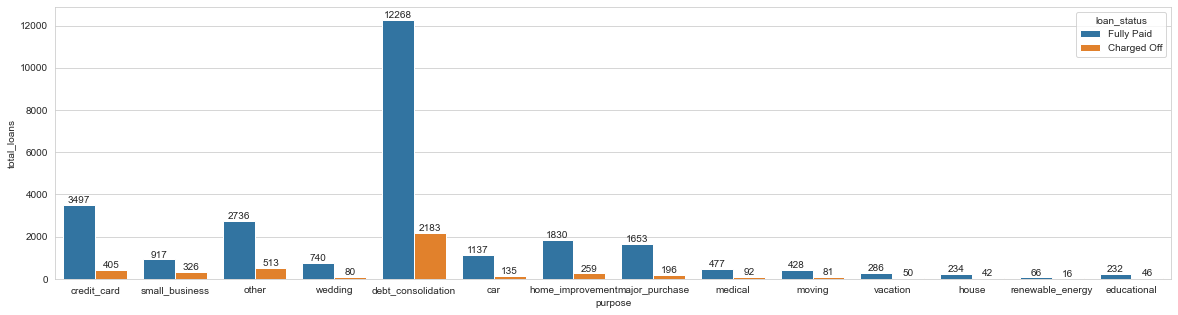

In [117]:
# Count loans grouped by purpose and status
plt.figure(figsize=[20,5])
ax = sns.countplot(x='purpose', hue="loan_status", data=df)
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

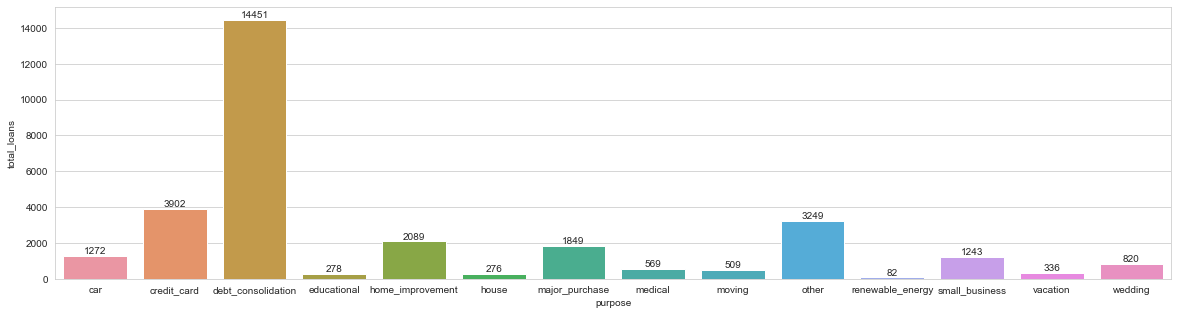

In [118]:
# Count loans by purpose
emp_length = pd.pivot_table(df, index='purpose', values='loan_status', aggfunc='count')

plt.figure(figsize=[20,5])
ax = sns.barplot(data=emp_length, x=emp_length.index, y='loan_status')
ax.bar_label(ax.containers[0])
ax.set(ylabel='total_loans')
plt.show()

For **grade column** let's review the distribution of loans by status.

We can see that Lending Club assigns the most A, B, and C loans, but we are interested in looking into defaulted loans.

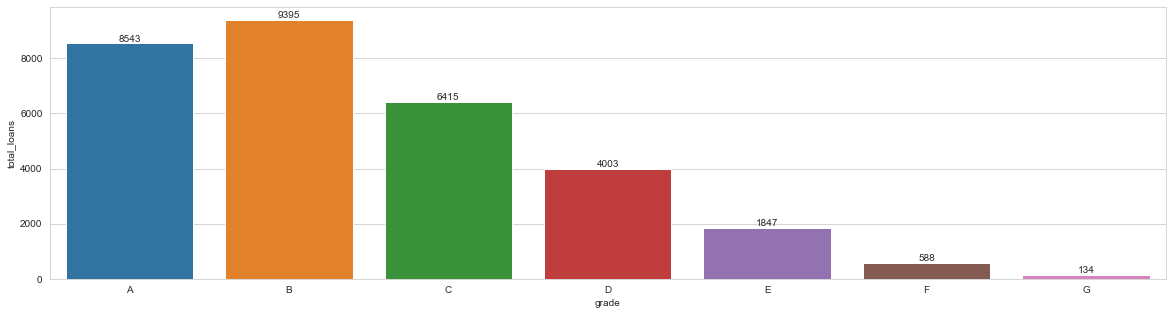

In [119]:
# Count loans by grade
grade = pd.pivot_table(df, index='grade', values='loan_status', aggfunc='count')

plt.figure(figsize=[20,5])
ax = sns.barplot(data=grade, x=grade.index, y='loan_status')
ax.bar_label(ax.containers[0])
ax.set(ylabel='total_loans')
plt.show()

We could simply say that defaulted loans are not much, but the interesting facts come from compairing their counts within their grades. Let's look at the percentage of defaulted loans within the grade:

- A: 6.04% 
- B: 12.50% 
- C: 17.27% 
- D: 22.43%
- E: 26.74%
- F: 31.63%
- G: 35.07%

**The lower/worst the grade assigned the more percentage of defaulted loans**.

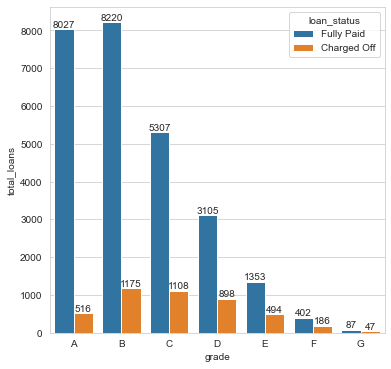

In [120]:
# Count loans grouped by grade and status
plt.figure(figsize=[6,6])
ax = sns.countplot(x='grade', hue="loan_status", data=df, order=['A','B','C','D','E','F','G'])
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

For **home_ownership column** let's review the distribution of loans by status.

Most of the borrowers requesting loans have a mortgaged or rented home. These two categories are not represented in "purpose" per se, but we could suggest that expenses to settle related to "debt_consolidation" include paying mortgaged properties or rents.

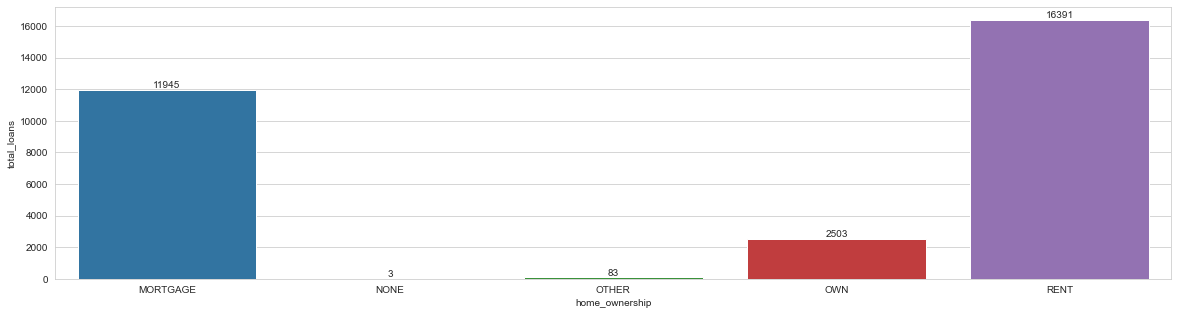

In [121]:
# Count loans by home_ownership
home_ownership = pd.pivot_table(df, index='home_ownership', values='loan_status', aggfunc='count')

plt.figure(figsize=[20,5])
ax = sns.barplot(data=home_ownership, x=home_ownership.index, y='loan_status')
ax.bar_label(ax.containers[0])
ax.set(ylabel='total_loans')
plt.show()

Let's look at the percentage of <i>total records</i> for defaulted loans by home ownership:

- MORTGAGE & RENT: 13.05%
- OWN: 1.20% 
- OTHER: 0.04%

**Mortgage and Rent categories of home ownership have the highest percentage of defaulted loans**.

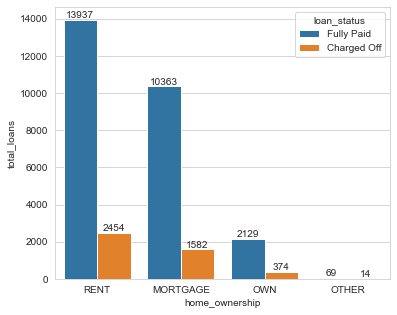

In [122]:
# Count loans grouped by home_ownership and status
plt.figure(figsize=[6,5])
ax = sns.countplot(x='home_ownership', hue="loan_status", data=df, order=['RENT','MORTGAGE','OWN','OTHER'])
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

For **verification_status column** let's review the distribution of loans.

Most of the incomes have been verified.

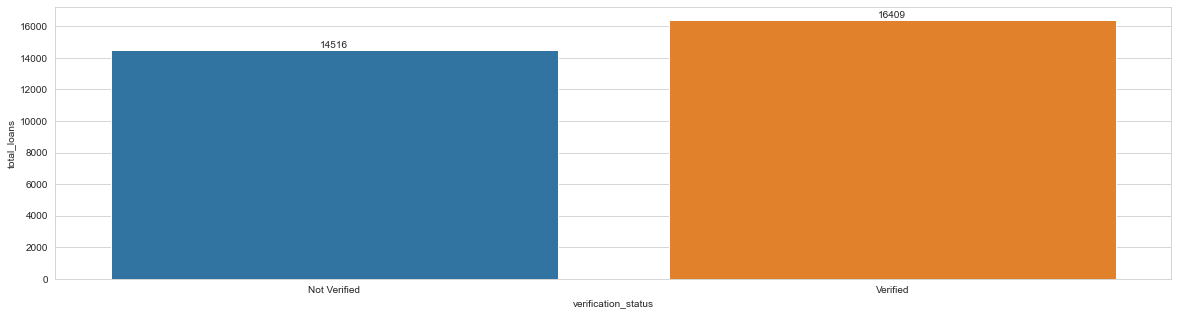

In [123]:
# Count loans by verification_status
verification_status = pd.pivot_table(df, index='verification_status', values='loan_status', aggfunc='count')

plt.figure(figsize=[20,5])
ax = sns.barplot(data=verification_status, x=verification_status.index, y='loan_status')
ax.bar_label(ax.containers[0])
ax.set(ylabel='total_loans')
plt.show()

Let's look at the percentage for defaulted loans by verification status:

- Not Verified: 12.62%
- Verified: 15.79%

**We cannot imply that Not Verified applications tend to default** (5.92% of total), Verified applications actually have more percentage of default (8.38% of total).

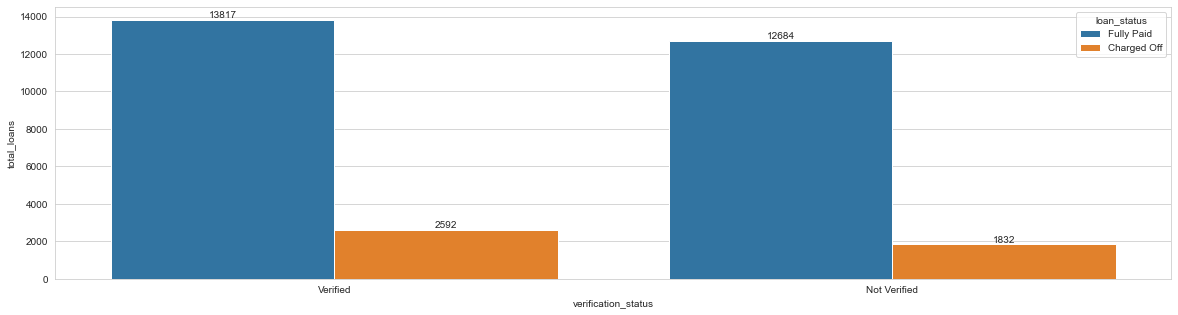

In [124]:
# Count loans grouped by verification and status
plt.figure(figsize=[20,5])
ax = sns.countplot(x='verification_status', hue="loan_status", data=df)
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

For **term column** let's review the distribution of loans.

More loans have been assigned to a 36 months term.

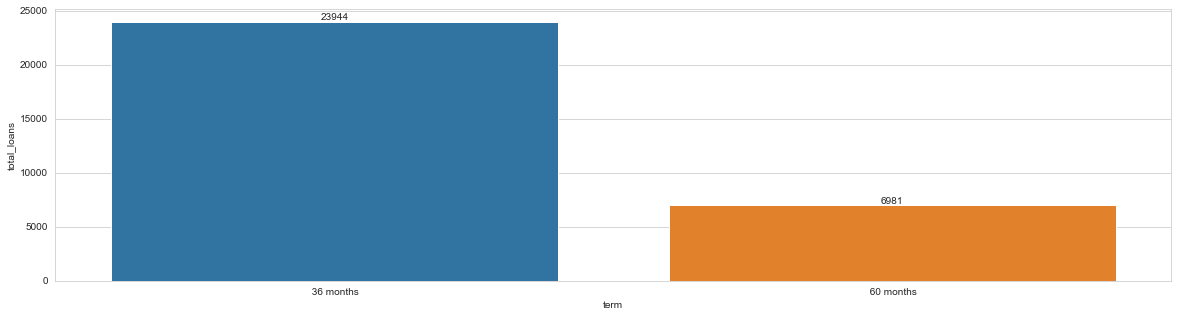

In [125]:
# Count loans by term
term = pd.pivot_table(df, index='term', values='loan_status', aggfunc='count')

plt.figure(figsize=[20,5])
ax = sns.barplot(data=term, x=term.index, y='loan_status')
ax.bar_label(ax.containers[0])
ax.set(ylabel='total_loans')
plt.show()

Let's look at the percentage for defaulted loans by term:

- 36 months: 11.05%
- 60 months: 25.46%

**We have more defaulted loans for 36 months term**, from the total applications the percentage is 8.55% (and 5.74% for 60 months).

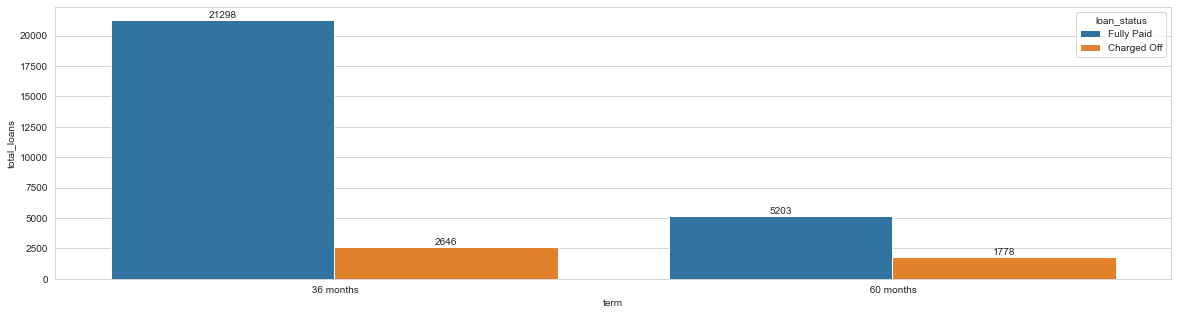

In [126]:
# Count loans grouped by term and status
plt.figure(figsize=[20,5])
ax = sns.countplot(x='term', hue="loan_status", data=df)
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

In [127]:
df.shape

(30925, 25)

#### Categorical variables review conclusions

Let's put here all our insights from reviewing relationship between categorical variables and loan status.

- Loans categorized as defaulted seem to remain in the same count range independently of the month, having the maximum value in December. For each month, around 1.5% of loans from the total by month are defaulted ones.
- People that has been employed for more than 10 years are the ones who mostly request loans (19.06% of total) and that end up in default (2.94% of total loans).
- "debt_consolidation" has the maximum count for loans (47.72% of total), and the category also includes the maximum value for defaulted loans (7.05% of total).
- The lower/worst the grade assigned the more percentage of defaulted loans within the grade counts. D, E, F, and G grades have more than 20% defaulted loans; B, C, D, E, F, and G defaulted loans represent 12.63% of the total.
- Mortgage and Rent categories of home ownership have the highest percentage of defaulted loans (13.05% of total).
- We cannot imply that Not Verified applications tend to default (5.92% of total), Verified applications actually have more percentage of default (8.38% of total).
- We have more defaulted loans for 36 months term, from the total applications the percentage is 8.55% (and 5.74% for 60 months).

To consider the high-related variables with loan status, we'll select the **ones with highest impact in terms of percentage of total**:
- emp_length
- purpose

### Numerical variables review
We'll review their distribution by loan status (Fully Paid, Charged Off).

In case of numerical variables we can identify relationships according to their histogram and boxplot comparisons by loan status (plotting for "Fully Paid" and for "Charged Off" separately).

In [128]:
# Create dataset for Fully Paid only loans
df_paid = df[df.loan_status == 'Fully Paid']

# Create dataset for Charged Off only loans
df_default = df[df.loan_status == 'Charged Off']

**annual_inc column**

From the histograms below we see a similar behaviour of annual_inc in both loan status, at first glance it looks like annual_inc and loan_status are independent.

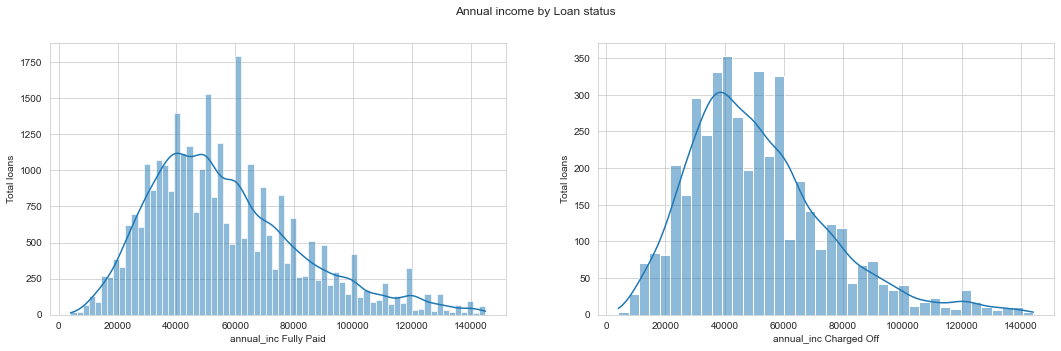

In [129]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('Annual income by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df, x='annual_inc', kde=True)
sns.histplot(ax=ax[1], data=df_default, x='annual_inc', kde=True)
ax[0].set(xlabel='annual_inc Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='annual_inc Charged Off', ylabel='Total loans')
plt.show()

If we look at the boxplots we can see that:
- Annual income of defaulted loans' borrowers has a smaller range than paid ones.
- Median and mean are higher for paid loans.
- Defaulted loans for "high" incomes are less likely to happen (annual income appears as an outlier). 

In conclusion, **people with defaulted loans have an annual income in general smaller than people who paid the loan**.

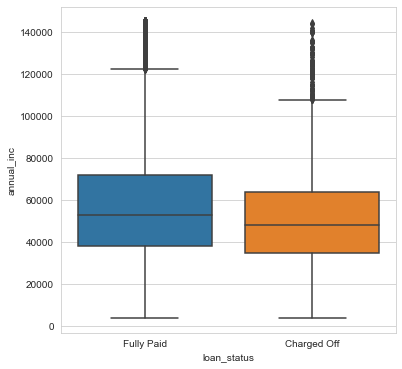

count     26501.000000
mean      57597.407056
std       26193.166180
min        4000.000000
25%       38400.000000
50%       53000.000000
75%       72000.000000
max      145000.000000
Name: annual_inc, dtype: float64
count      4424.000000
mean      51369.072871
std       23804.707054
min        4080.000000
25%       35000.000000
50%       48000.000000
75%       64000.000000
max      144240.000000
Name: annual_inc, dtype: float64


In [130]:
# Create boxplots
plt.figure(figsize=[6,6])
sns.boxplot(x='loan_status', y='annual_inc', data=df)
plt.show()

# Print description
print(df_paid.annual_inc.describe())
print(df_default.annual_inc.describe())

**delinq_2yrs column**

From the histograms below we see a similar behaviour of delinq_2yrs in both loan status, at first glance it looks like delinq_2yrs and loan_status are independent.

In this case there makes no sense to create a boxplot as the mode is value zero. Mean value is similar in both cases and we cannot see a trend for any category.

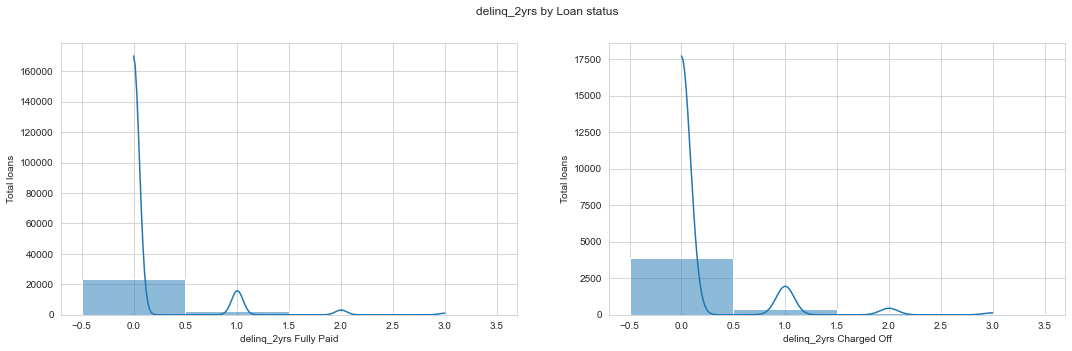

In [131]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('delinq_2yrs by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='delinq_2yrs', kde=True, discrete=True)
sns.histplot(ax=ax[1], data=df_default, x='delinq_2yrs', kde=True, discrete=True)
ax[0].set(xlabel='delinq_2yrs Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='delinq_2yrs Charged Off', ylabel='Total loans')
plt.show()

If we plot the total loans by delinq_2yrs values, we see that the more incidencies the greater the percentage of defaulted loans within each value, but the percentage from total loans for each value is less than 1.5%.

And we can see that for zero incidencies in the last 30 days there are more defaulted loans. We cannot spot any other clear trend from this variable.

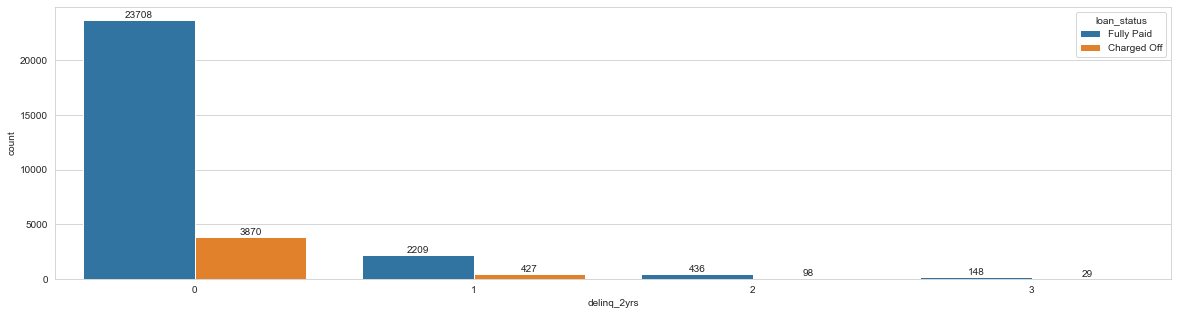

In [132]:
# Count loans grouped by delinq_2yrs and status
plt.figure(figsize=[20,5])
ax = sns.countplot(x='delinq_2yrs', hue="loan_status", data=df)
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
plt.show()

**dti column**

From the histograms below we see a similar behaviour of dti in both loan status, at first glance it looks like dti and loan_status are independent.

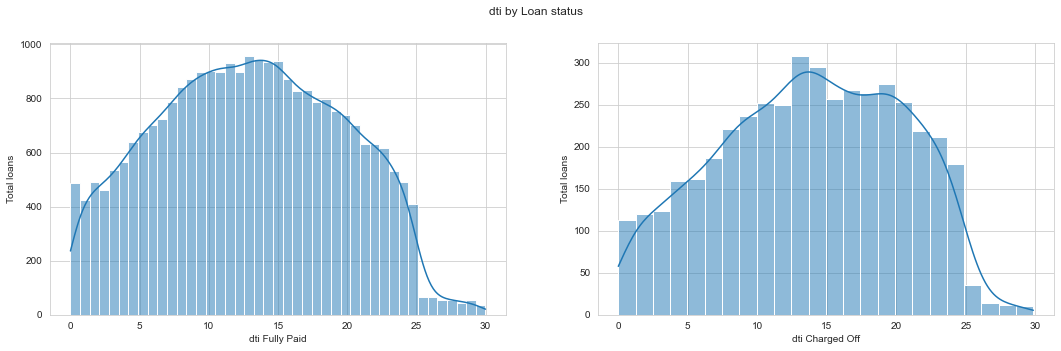

In [133]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('dti by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='dti', kde=True)
sns.histplot(ax=ax[1], data=df_default, x='dti', kde=True)
ax[0].set(xlabel='dti Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='dti Charged Off', ylabel='Total loans')
plt.show()

If we look at the boxplots we can see that:
- DTI range is similar for both categories.
- Median and mean are greater for defaulted loans.

Let's remember that DTI is a ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

With the boxplot information and knowing that people with defaulted loans have an annual income in "average" smaller, we can say that **in "average" borrowers with defaulted loans make greater monthly debt payments than the ones who paid the loan**.

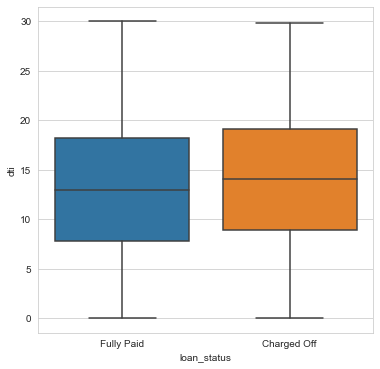

count    26501.000000
mean        12.949931
std          6.663493
min          0.000000
25%          7.770000
50%         12.930000
75%         18.170000
max         29.990000
Name: dti, dtype: float64
count    4424.000000
mean       13.800319
std         6.590838
min         0.000000
25%         8.875000
50%        14.030000
75%        19.150000
max        29.850000
Name: dti, dtype: float64


In [134]:
# Create boxplots
plt.figure(figsize=[6,6])
sns.boxplot(x='loan_status', y='dti', data=df)
plt.show()

# Print description
print(df_paid.dti.describe())
print(df_default.dti.describe())

**inq_last_6mths column**

From the histograms below we see a similar behaviour of inq_last_6mths in both loan status, at first glance it looks like inq_last_6mths and loan_status are independent, but probability of values for defaulted loans seems to be higher.

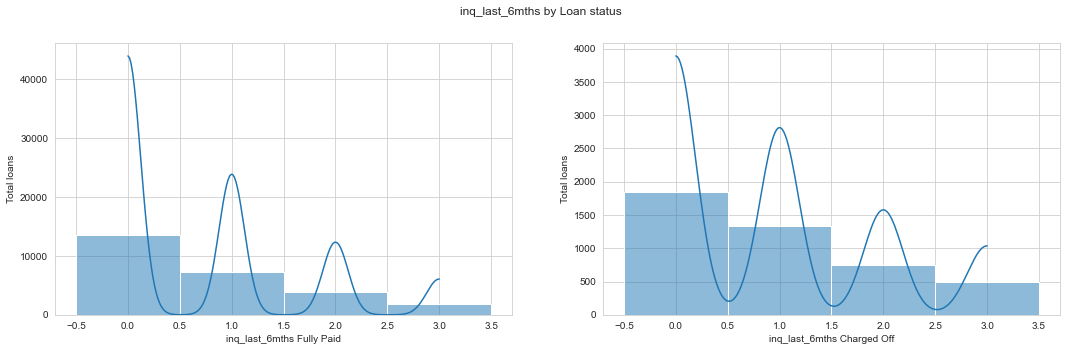

In [135]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('inq_last_6mths by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='inq_last_6mths', kde=True, discrete=True)
sns.histplot(ax=ax[1], data=df_default, x='inq_last_6mths', kde=True, discrete=True)
ax[0].set(xlabel='inq_last_6mths Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='inq_last_6mths Charged Off', ylabel='Total loans')
plt.show()

If we look at the boxplots we can see that:
- For both categories there is a positive skew (values tend to agglomerate in first values).
- Range of inquiries for defaulted loans is greater.
- More than 2 inquiries are rare for paid loans (three value for outliers).
- While 50% of the time there are zero inquiries for paid loans, one inquiry can be seen for defaulted ones.
- 75% of inquiries for defaulted loans are between zero and two, while for paid ones goes up to one.

With the boxplot information and remembering that inq_last_6mths excludes auto and mortgage inquiries, we can say that **borrowers with defaulted loans have more inquiries done to their debts in last 6 months, which is a strong indicator of them looking more for lenders**.

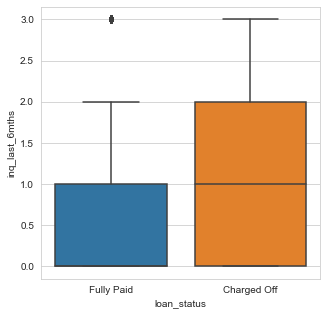

count    26501.000000
mean         0.774348
std          0.939984
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: inq_last_6mths, dtype: float64
count    4424.000000
mean        0.974231
std         1.015487
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: inq_last_6mths, dtype: float64


In [136]:
# Create boxplots
plt.figure(figsize=[5,5])
sns.boxplot(x='loan_status', y='inq_last_6mths', data=df)
plt.show()

# Print description
print(df_paid.inq_last_6mths.describe())
print(df_default.inq_last_6mths.describe())

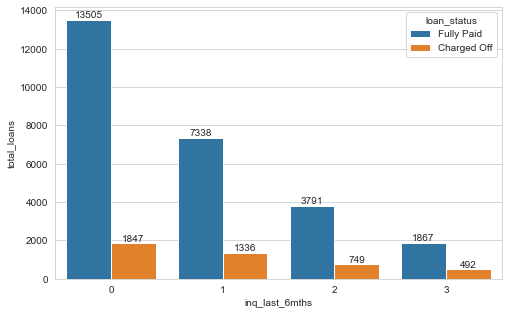

In [137]:
# Inquiries for defaulted loans
plt.figure(figsize=[8,5])
ax = sns.countplot(x='inq_last_6mths', hue="loan_status", data=df)
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

**int_rate column**

From the histograms below we see a clearly different behaviour of int_rate by loan status.

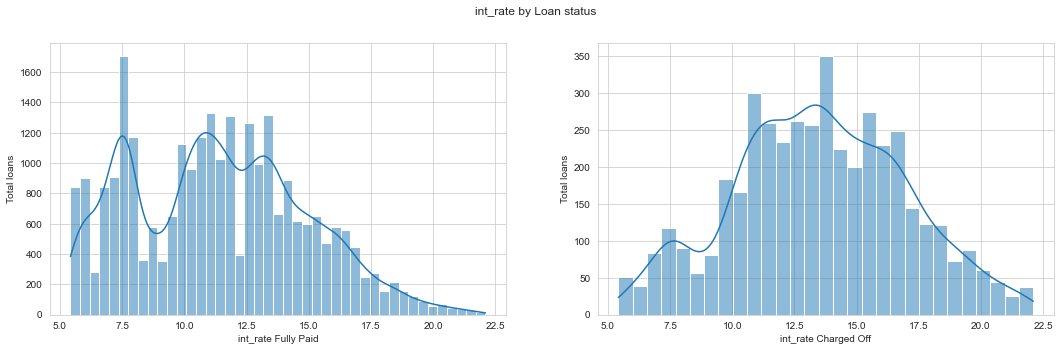

In [138]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('int_rate by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='int_rate', kde=True)
sns.histplot(ax=ax[1], data=df_default, x='int_rate', kde=True)
ax[0].set(xlabel='int_rate Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='int_rate Charged Off', ylabel='Total loans')
plt.show()

If we look at the boxplots we can see that:
- Range for both categories is the same (5.42% to 22.11%).
- Median and mean of data for defaulted loans are clearly higher.

With the boxplot information we can say that **borrowers with defaulted loans were given in general higher interest rates than the ones who were able to pay**.

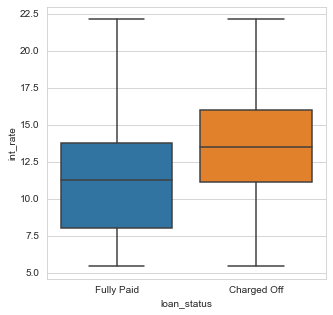

count    26501.000000
mean        11.393781
std          3.489142
min          5.420000
25%          8.000000
50%         11.260000
75%         13.790000
max         22.110000
Name: int_rate, dtype: float64
count    4424.000000
mean       13.504668
std         3.494754
min         5.420000
25%        11.110000
50%        13.490000
75%        15.990000
max        22.110000
Name: int_rate, dtype: float64


In [139]:
# Create boxplots
plt.figure(figsize=[5,5])
sns.boxplot(x='loan_status', y='int_rate', data=df)
plt.show()

# Print description
print(df_paid.int_rate.describe())
print(df_default.int_rate.describe())

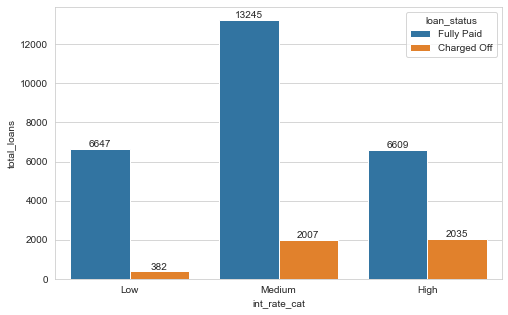

In [140]:
# Loans by categorized interest rate
plt.figure(figsize=[8,5])
ax = sns.countplot(x='int_rate_cat', hue="loan_status", data=df, order=['Low','Medium','High'])
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

**installment column**

From the histograms below we see a similar behaviour of installment in both loan status, at first glance it looks like installment and loan_status are independent.

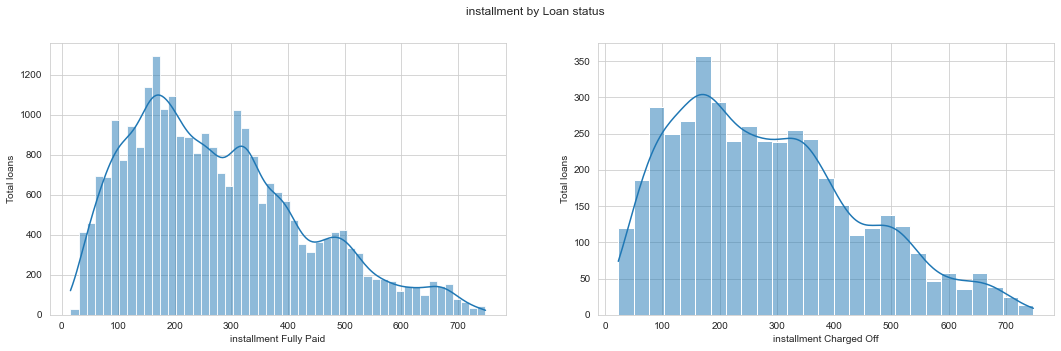

In [141]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('installment by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='installment', kde=True)
sns.histplot(ax=ax[1], data=df_default, x='installment', kde=True)
ax[0].set(xlabel='installment Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='installment Charged Off', ylabel='Total loans')
plt.show()

If we look at the boxplots we can see that:
- Even if maximum value for both categories is similar, rare values (outliers) for paid loans are the ones greater than 696.675, while for defaulted ones rare values are above 724.77625.
- For defaulted loans the installment minimum value is greater: installments for defaulted loans start at 15.69 while for paid ones starts at 22.79.
- Median and mean of data for defaulted loans are higher.

With the boxplot information we can say that **borrowers with defaulted loans were given in general higher monthly payments than the ones who were able to pay**.

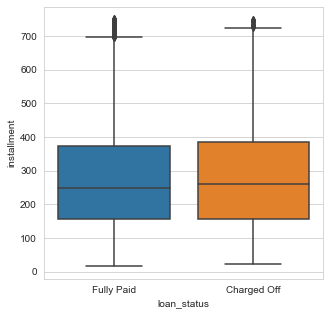

count    26501.000000
mean       276.077633
std        156.128932
min         15.690000
25%        155.750000
50%        248.890000
75%        372.120000
max        748.920000
Name: installment, dtype: float64
count    4424.000000
mean      282.320626
std       160.423666
min        22.790000
25%       156.557500
50%       259.630000
75%       383.845000
max       748.170000
Name: installment, dtype: float64


In [142]:
# Create boxplots
plt.figure(figsize=[5,5])
sns.boxplot(x='loan_status', y='installment', data=df)
plt.show()

# Print description
print(df_paid.installment.describe())
print(df_default.installment.describe())

**loan_amnt column**

From the histograms below we see a different behaviour of loan_amnt by loan status, at first glance it looks like loan_amnt affects more the amount of defaulted loans (higher probabilities for values).

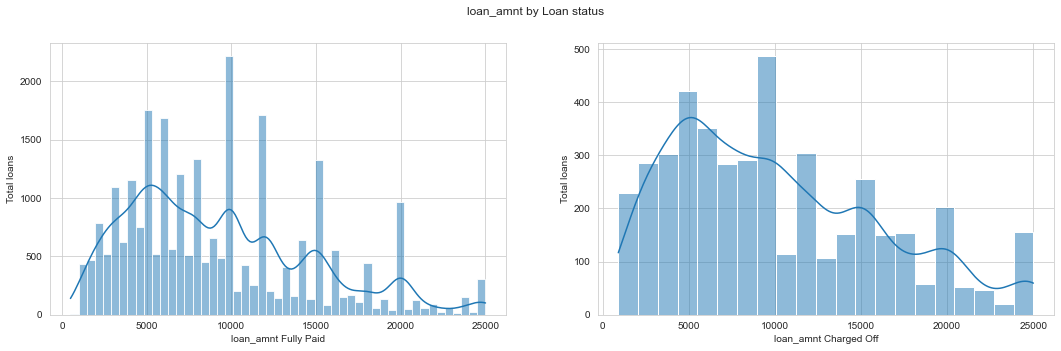

In [143]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('loan_amnt by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='loan_amnt', kde=True)
sns.histplot(ax=ax[1], data=df_default, x='loan_amnt', kde=True)
ax[0].set(xlabel='loan_amnt Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='loan_amnt Charged Off', ylabel='Total loans')
plt.show()

If we look at the boxplots we can see that:
- Even if maximum value for both categories is the same (25,000), rare values (outliers) for paid loans are the ones greater than 23,125, while for defaulted ones rare values are above 28,750.
- Median and mean for defaulted loans are higher.

With the boxplot information we can say that **borrowers with defaulted loans asked in general for greater loan amounts than the ones who were able to pay**.

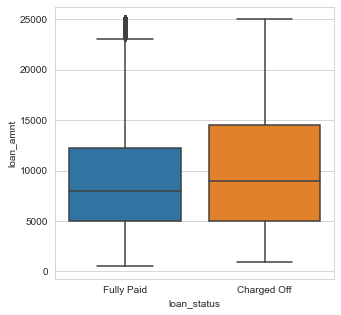

count    26501.000000
mean      9309.166635
std       5483.080390
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12250.000000
max      25000.000000
Name: loan_amnt, dtype: float64
count     4424.000000
mean     10083.278707
std       6087.870115
min        900.000000
25%       5000.000000
50%       9000.000000
75%      14500.000000
max      25000.000000
Name: loan_amnt, dtype: float64


In [144]:
# Create boxplots
plt.figure(figsize=[5,5])
sns.boxplot(x='loan_status', y='loan_amnt', data=df)
plt.show()

# Print description
print(df_paid.loan_amnt.describe())
print(df_default.loan_amnt.describe())

**open_acc column**

From the histograms below we see a similar behaviour of open_acc in both loan status, at first glance it looks like open_acc and loan_status are independent.

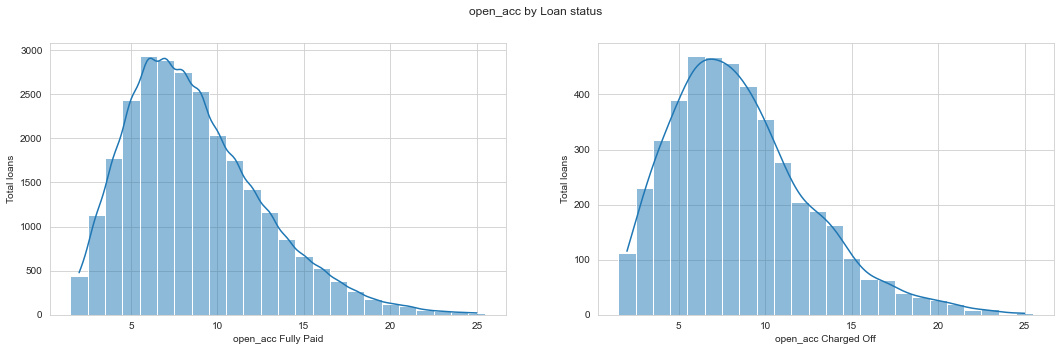

In [145]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('open_acc by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='open_acc', kde=True, discrete=True)
sns.histplot(ax=ax[1], data=df_default, x='open_acc', kde=True, discrete=True)
ax[0].set(xlabel='open_acc Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='open_acc Charged Off', ylabel='Total loans')
plt.show()

If we look at the boxplots we can see that:
- For both categories the distribution of values is the same.
- Mean value is slightly higher for paid loans.

With the boxplot information we cannot see a trend for any category.

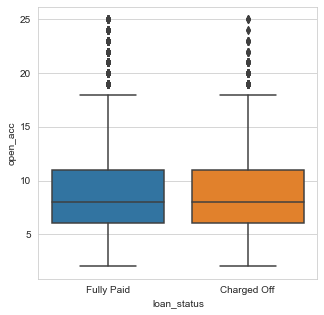

count    26501.000000
mean         8.713747
std          3.972445
min          2.000000
25%          6.000000
50%          8.000000
75%         11.000000
max         25.000000
Name: open_acc, dtype: float64
count    4424.000000
mean        8.570072
std         4.046985
min         2.000000
25%         6.000000
50%         8.000000
75%        11.000000
max        25.000000
Name: open_acc, dtype: float64


In [146]:
# Create boxplots
plt.figure(figsize=[5,5])
sns.boxplot(x='loan_status', y='open_acc', data=df)
plt.show()

# Print description
print(df_paid.open_acc.describe())
print(df_default.open_acc.describe())

**pub_rec column**

From the histograms below we see that after cleaning the data we obtained a two-values column with similar behaviour of pub_rec for both loan status, at first glance it looks like pub_rec and loan_status are independent.

In this case there makes no sense to create a boxplot as the mode is value zero. Mean value is similar in both cases and we cannot see a trend for any category.

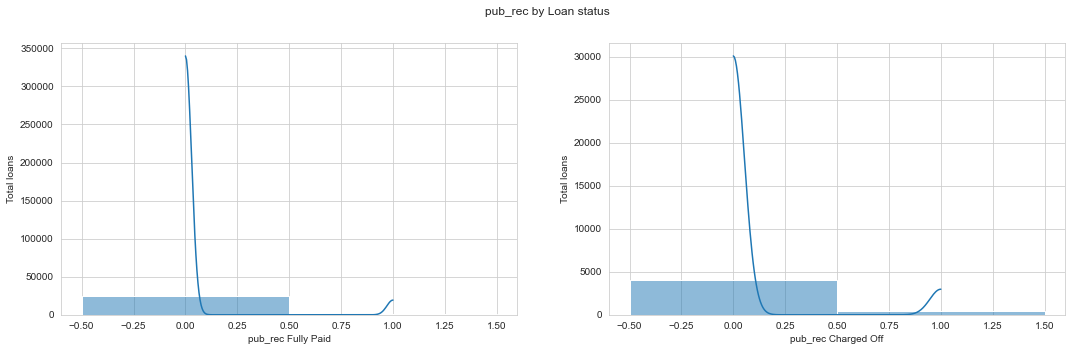

In [147]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('pub_rec by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='pub_rec', kde=True, discrete=True)
sns.histplot(ax=ax[1], data=df_default, x='pub_rec', kde=True, discrete=True)
ax[0].set(xlabel='pub_rec Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='pub_rec Charged Off', ylabel='Total loans')
plt.show()

If we plot the total loans by pub_rec values, the percentage of total loans for zero derogatory public records is greater than for one, but still represents less than 1.5% of total loans. We cannot spot any other clear trend from this variable.

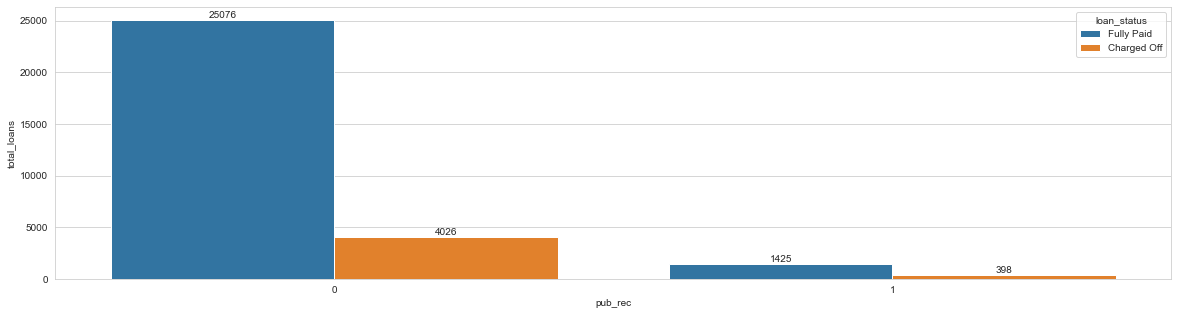

In [148]:
# Count loans grouped by grade and status
plt.figure(figsize=[20,5])
ax = sns.countplot(x='pub_rec', hue="loan_status", data=df)
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

**pub_rec_bankruptcies column**

From the histograms below we see that after cleaning the data we obtained a two-values column with similar behaviour of pub_rec_bankruptcies for both loan status, at first glance it looks like pub_rec_bankruptcies and loan_status are independent.

In this case there makes no sense to create a boxplot as the mode is value zero. Mean value is similar in both cases and we cannot see a trend for any category.

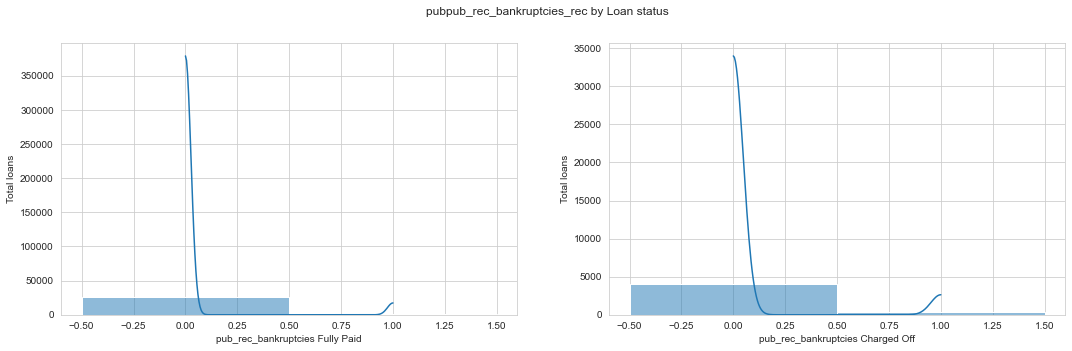

In [149]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('pubpub_rec_bankruptcies_rec by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='pub_rec_bankruptcies', kde=True, discrete=True)
sns.histplot(ax=ax[1], data=df_default, x='pub_rec_bankruptcies', kde=True, discrete=True)
ax[0].set(xlabel='pub_rec_bankruptcies Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='pub_rec_bankruptcies Charged Off', ylabel='Total loans')
plt.show()

If we plot the total loans by pub_rec_bankruptcies values, the percentage of total loans for zero public record bankruptcies is greater than for one, but still represents less than 1.5% of total loans. We cannot spot any other clear trend from this variable.

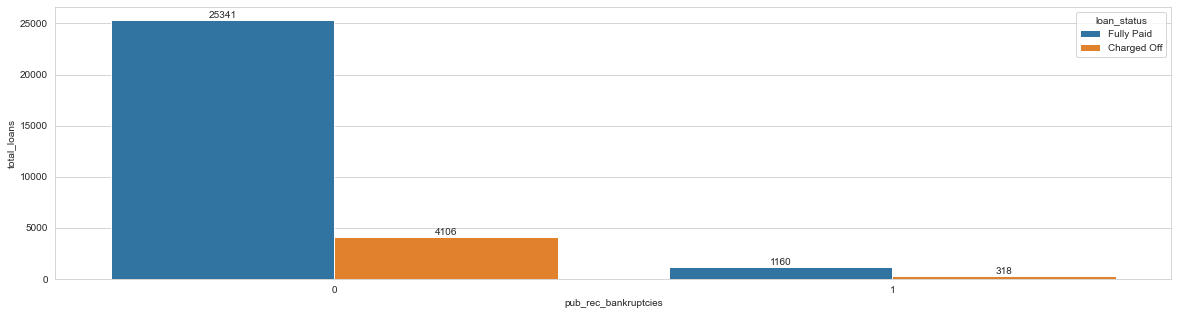

In [150]:
# Count loans grouped by pub_rec_bankruptcies and status
plt.figure(figsize=[20,5])
ax = sns.countplot(x='pub_rec_bankruptcies', hue="loan_status", data=df)
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

**revol_bal column**

From the histograms below we see a similar behaviour of revol_bal in both loan status, at first glance it looks like revol_bal and loan_status are independent.

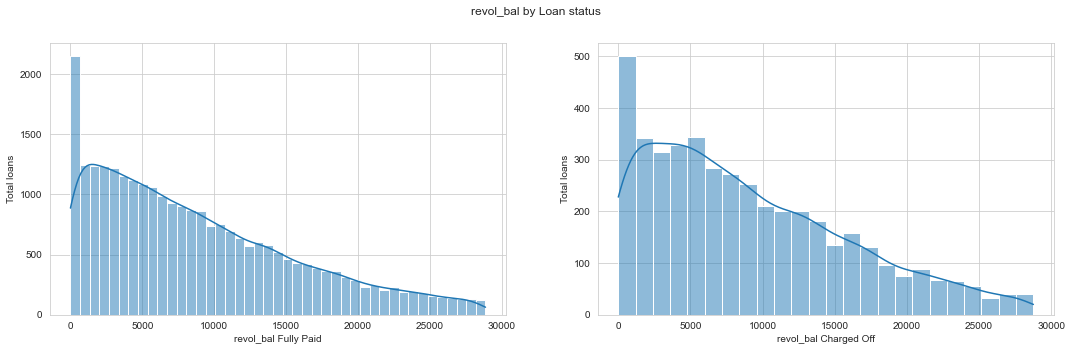

In [151]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('revol_bal by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='revol_bal', kde=True)
sns.histplot(ax=ax[1], data=df_default, x='revol_bal', kde=True)
ax[0].set(xlabel='revol_bal Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='revol_bal Charged Off', ylabel='Total loans')
plt.show()

If we look at the boxplots we can see that:
- Values range is similar for both categories, slightly higher for paid loans.
- Median and data at 75% is pretty similar for both categories, slightly higher for paid loans.

With the boxplot information we cannot see a trend for any category.

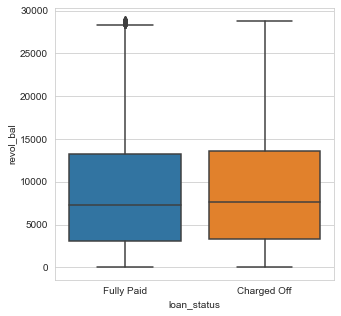

count    26501.000000
mean      8832.492661
std       7011.810623
min          0.000000
25%       3098.000000
50%       7259.000000
75%      13207.000000
max      28856.000000
Name: revol_bal, dtype: float64
count     4424.000000
mean      9080.285714
std       6996.409336
min          0.000000
25%       3366.250000
50%       7608.000000
75%      13564.250000
max      28762.000000
Name: revol_bal, dtype: float64


In [152]:
# Create boxplots
plt.figure(figsize=[5,5])
sns.boxplot(x='loan_status', y='revol_bal', data=df)
plt.show()

# Print description
print(df_paid.revol_bal.describe())
print(df_default.revol_bal.describe())

**revol_util column**

From the histograms below we see a clearly different behaviour of revol_util by loan status.

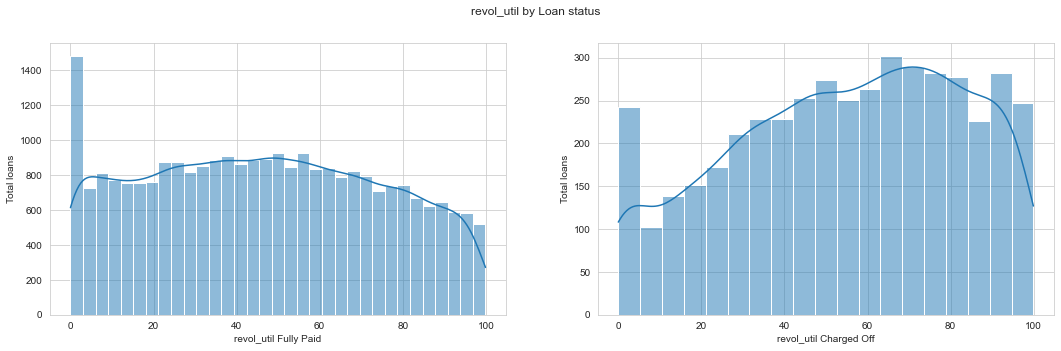

In [153]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('revol_util by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='revol_util', kde=True)
sns.histplot(ax=ax[1], data=df_default, x='revol_util', kde=True)
ax[0].set(xlabel='revol_util Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='revol_util Charged Off', ylabel='Total loans')
plt.show()

If we look at the boxplots we can see that:
- Values range for both categories is the same.
- Median and mean are clearly higher for defaulted loans than for paid ones. 75% of borrowers have up to 77.5 utilization rate, while for paid loans they have up to 69.6.

Let's remember that revol_util is the revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

With the boxplot information we can say that **borrowers with defaulted loans use more credit relative to all available revolving credit that the ones who were able to pay**.

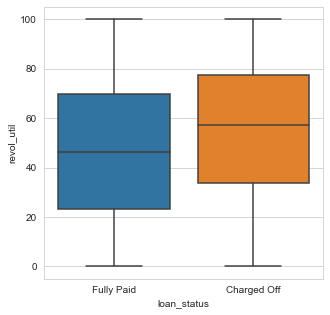

count    26501.000000
mean        46.623602
std         28.119992
min          0.000000
25%         23.200000
50%         46.300000
75%         69.600000
max         99.900000
Name: revol_util, dtype: float64
count    4424.000000
mean       54.606935
std        27.626761
min         0.000000
25%        33.600000
50%        57.000000
75%        77.500000
max        99.900000
Name: revol_util, dtype: float64


In [154]:
# Create boxplots
plt.figure(figsize=[5,5])
sns.boxplot(x='loan_status', y='revol_util', data=df)
plt.show()

# Print description
print(df_paid.revol_util.describe())
print(df_default.revol_util.describe())

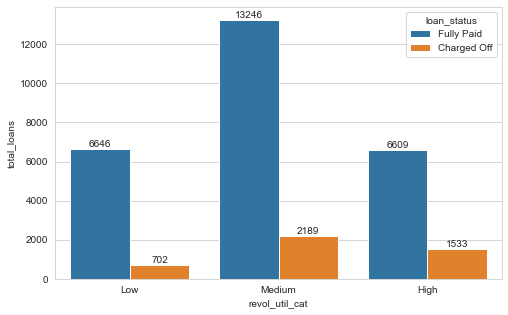

In [155]:
# Loans by categorized revol_util
plt.figure(figsize=[8,5])
ax = sns.countplot(x='revol_util_cat', hue="loan_status", data=df, order=['Low','Medium','High'])
#Show labels on top of bars
for container in ax.containers:
    ax.bar_label(container)
ax.set(ylabel='total_loans')
plt.show()

**total_acc column**

From the histograms below we see a similar behaviour of revol_bal in both loan status, at first glance it looks like revol_bal and loan_status are independent.

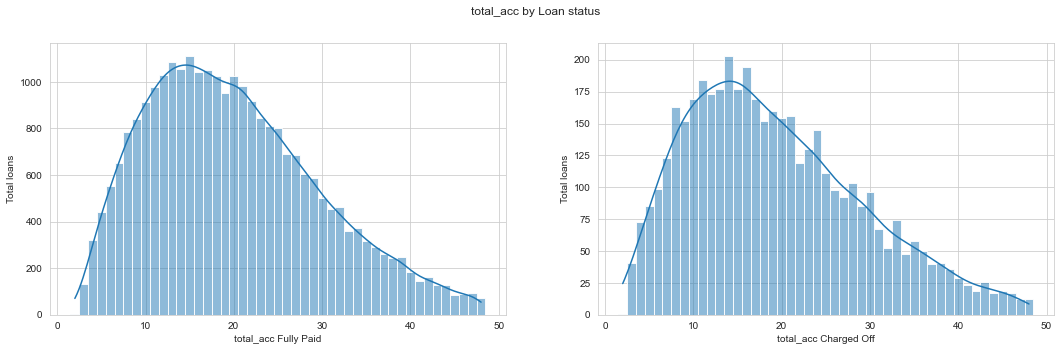

In [156]:
# To show two graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Title for plots
fig.suptitle('total_acc by Loan status')

# Create histograms
sns.histplot(ax=ax[0], data=df_paid, x='total_acc', kde=True, discrete=True)
sns.histplot(ax=ax[1], data=df_default, x='total_acc', kde=True, discrete=True)
ax[0].set(xlabel='total_acc Fully Paid', ylabel='Total loans')
ax[1].set(xlabel='total_acc Charged Off', ylabel='Total loans')
plt.show()

If we look at the boxplots we can see that:
- Range for both categories is the same.
- Median is slightly higher for paid loans, 75% of data has the same value (26.0).
- Outliers range is the same for both categories.

With the boxplot information we cannot say there is a trend for any category.

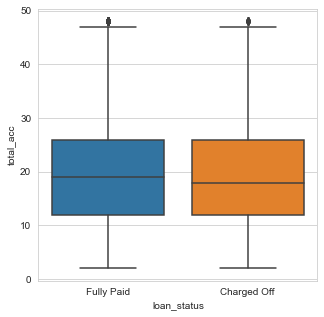

count    26501.000000
mean        20.014565
std          9.747581
min          2.000000
25%         12.000000
50%         19.000000
75%         26.000000
max         48.000000
Name: total_acc, dtype: float64
count    4424.000000
mean       19.308544
std         9.903649
min         2.000000
25%        12.000000
50%        18.000000
75%        26.000000
max        48.000000
Name: total_acc, dtype: float64


In [157]:
# Create boxplots
plt.figure(figsize=[5,5])
sns.boxplot(x='loan_status', y='total_acc', data=df)
plt.show()

# Print description
print(df_paid.total_acc.describe())
print(df_default.total_acc.describe())

#### Quantitative variables review conclusions

Let's put here all our insights from reviewing relationship between quantitavie variables and loan status.

- Borrowers with defaulted loans have an annual income in general smaller than people who paid the loan (income between 4,080 and 144,240).
- Borrowers with defaulted loans make in general greater monthly debt payments than the ones who paid the loan (75% of time having up to 19.15 DTI).
- Borrowers with defaulted loans have more inquiries done to their debts in last 6 months, which is a strong indicator of them looking more for lenders: 75% of inquiries for defaulted loans are between zero and two, while for paid ones goes up to one.
- Borrowers with defaulted loans were given in general higher interest rates than the ones who were able to pay (75% of time going up to 15.99% with a maximum of 22.11%).
- Borrowers with defaulted loans were given in general higher monthly payments than the ones who were able to pay. For defaulted loans the installment minimum value is greater: installments for defaulted loans start at 22.79 while for paid ones starts at 15.69.
- Borrowers with defaulted loans asked in general for greater loan amounts than the ones who were able to pay (75% of time going up to 14,500 and with a maximum of 25,000).
- Borrowers with defaulted loans use more credit relative to all available revolving credit that the ones who were able to pay: 75% of borrowers have up to 77.5 utilization rate, while for paid loans they have up to 69.6.

To consider the high-related variables with loan status, we'll select the ones with highest impact in terms of distribution behaviour:
- inq_last_6mths
- int_rate
- revol_util

### Indicators of default

Following variables were found to have an impact over the total amount of defaulted loans:
- emp_length
- purpose
- grade
- home_ownership
- annual_inc
- dti
- inq_last_6mths
- int_rate
- installment
- loan_amnt
- revol_util

From these variables, and accordingly to their distributions and behaviour by loan status, following ones have a high impact over the total amount of defaulted loans, and can be considered as **strong indicators of default**:
- emp_length
- purpose
- inq_last_6mths
- int_rate
- revol_util